In [1]:
import os
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from bs4 import BeautifulSoup
import urllib.parse as urlparse

In [2]:
from matplotlib import font_manager
f_path = "/Library/Fonts/Arial Unicode.ttf"
font_manager.FontProperties(fname=f_path).get_name()
from matplotlib import rc
rc('font', family = "Arial Unicode MS")

# 1. 전체데이터 전처리

## 1) 데이터 로드

In [3]:
df_0 = pd.read_csv("./skt_raw_data/"+os.listdir("./skt_raw_data/")[0])

In [4]:
df_1 = pd.read_csv("./skt_raw_data/"+os.listdir("./skt_raw_data/")[1])

In [5]:
df = df_0.append(df_1)

In [6]:
for i in range(2, 73):
    try:
        df_0 = pd.read_csv("./skt_raw_data/"+os.listdir("./skt_raw_data/")[i])
        df = df.append(df_0)
    except:
        pass

df.tail()


,일자,요일,시간대,업종,시도,시군구,읍면동,통화건수,이용건수,통화량
2624,20140430,수,22,피자,NaN,NaN,NaN,NaN,418.0,NaN
2625,20140430,수,23,음식점-족발/보쌈전문,NaN,NaN,NaN,NaN,118.0,NaN
2626,20140430,수,23,음식점-중국음식,NaN,NaN,NaN,NaN,175.0,NaN
2627,20140430,수,23,치킨,NaN,NaN,NaN,NaN,1707.0,NaN
2628,20140430,수,23,피자,NaN,NaN,NaN,NaN,109.0,NaN


In [7]:
# raw 데이터 저장
df.to_csv("./skt_raw_data.csv")

## 2) 데이터 정리

In [8]:
# 일자, 시간대별 정렬 
df = df.sort_values(["일자", "시간대"])

In [9]:
df.reset_index(drop = True, inplace=True)
df.tail()

,일자,요일,시간대,업종,시도,시군구,읍면동,통화건수,이용건수,통화량
5445988,20190930,월,23,피자,서울특별시,서초구,양재동,5.0,NaN,NaN
5445989,20190930,월,23,피자,서울특별시,성북구,동선동2가,5.0,NaN,NaN
5445990,20190930,월,23,피자,서울특별시,송파구,가락동,5.0,NaN,NaN
5445991,20190930,월,23,피자,서울특별시,영등포구,영등포동5가,5.0,NaN,NaN
5445992,20190930,월,23,피자,서울특별시,중랑구,면목동,5.0,NaN,NaN


In [10]:
# 중복된 값 없는지 확인
display(df[df.duplicated()])

,일자,요일,시간대,업종,시도,시군구,읍면동,통화건수,이용건수,통화량


In [11]:
# 컬럼명은 다르지만 동일한 "통화주문건수" 임음 확인하고 합치고 기존 컬럼은 지우기
df["통화건수"].fillna(0, inplace=True)
df["이용건수"].fillna(0, inplace=True)
df["통화량"].fillna(0, inplace=True)

In [12]:
df["통화건수"] = df["통화건수"] +df["이용건수"]+df["통화량"]

In [13]:
df.drop(columns=["이용건수","통화량"], inplace=True)

In [14]:
# 데이터 값 정리
df.loc[df["업종"] == '음식점-족발/보쌈전문', "업종"] = "족발/보쌈"
df.loc[df["업종"] == '음식점-중국음식', "업종"] = "중식"

In [15]:
df.head()

,일자,요일,시간대,업종,시도,시군구,읍면동,통화건수
0,20131001,화,0,피자,NaN,NaN,NaN,39.0
1,20131001,화,0,족발/보쌈,NaN,NaN,NaN,61.0
2,20131001,화,0,중식,NaN,NaN,NaN,142.0
3,20131001,화,0,치킨,NaN,NaN,NaN,550.0
4,20131001,화,1,피자,NaN,NaN,NaN,25.0


In [16]:
# 서울아닌 지역 포함되어 있는지 확인 후 있으면 해당 row 삭제
not_seoul = df[df["시도"]!="서울특별시"][df["시도"].notnull()].index
df = df.drop(not_seoul).reset_index(drop = True)

## 3) 데이터프레임 저장

In [17]:
# 2013년부터의 테이터 저장
df.to_csv("skt_data_2013-2019.csv")

In [18]:
# 2016년 10월 1일 이후 데이터만 추출 및 저장
df_1 = df[df["일자"] >= 20161001]

In [19]:
df_1.reset_index(drop=True, inplace=True)

In [20]:
df_1.to_csv("skt_data_2016-2019.csv")

# 2. 시간기준 데이터 분석

## 1) 데이터 로드

In [21]:
# 연도별 주문량 비교를 위한 2013~ 데이터, 그외 주문량 비교를 위한 2016~ 데이터
# 2014년 9월 10월에 주문량 특이점이 발생한 점, 2016년 10월 이후 원본데이터가 통일성이 유지된 점을 근거로 
# 연도별 주문량 비교를 제외한 분석은 2016.10~으로 진행하였음
df_2013 = pd.read_csv("./skt_data_2013-2019.csv")

In [23]:
df_2013.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
df_2013.head()

,일자,요일,시간대,업종,시도,시군구,읍면동,통화건수
0,20131001,화,0,피자,NaN,NaN,NaN,39.0
1,20131001,화,0,족발/보쌈,NaN,NaN,NaN,61.0
2,20131001,화,0,중식,NaN,NaN,NaN,142.0
3,20131001,화,0,치킨,NaN,NaN,NaN,550.0
4,20131001,화,1,피자,NaN,NaN,NaN,25.0


In [24]:
# 컬럼명 영문 변경
df_2013.columns=["date", "weekday", "hour", "menu", "sido", "sigungu", "dong", "count"]

In [25]:
df_2013.tail()

,date,weekday,hour,menu,sido,sigungu,dong,count
5445984,20190930,월,23,피자,서울특별시,서초구,양재동,5.0
5445985,20190930,월,23,피자,서울특별시,성북구,동선동2가,5.0
5445986,20190930,월,23,피자,서울특별시,송파구,가락동,5.0
5445987,20190930,월,23,피자,서울특별시,영등포구,영등포동5가,5.0
5445988,20190930,월,23,피자,서울특별시,중랑구,면목동,5.0


In [26]:
# 서울 전체 지역의 일자별을 확인하고자 하므로 
# 시군구, 동은 시간 및 업종으로 grouping 후 컬럼 삭제
df_2013 = df_2013.drop(columns = ["sigungu", "dong"])

In [27]:
df_2013= df_2013.groupby(by=["date", "weekday", "hour","menu"], as_index=False).sum()

In [28]:
df_2013.tail()

,date,weekday,hour,menu,count
203563,20190930,월,22,피자,205.0
203564,20190930,월,23,족발/보쌈,65.0
203565,20190930,월,23,중식,90.0
203566,20190930,월,23,치킨,392.0
203567,20190930,월,23,피자,75.0


In [29]:
df_2013.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203568 entries, 0 to 203567
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   date     203568 non-null  int64  
 1   weekday  203568 non-null  object 
 2   hour     203568 non-null  int64  
 3   menu     203568 non-null  object 
 4   count    203568 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [30]:
df_2016 = df_2013[df_2013["date"] >= 20161001].reset_index(drop=True)

In [31]:
df_2013.head()

,date,weekday,hour,menu,count
0,20131001,화,0,족발/보쌈,61.0
1,20131001,화,0,중식,142.0
2,20131001,화,0,치킨,550.0
3,20131001,화,0,피자,39.0
4,20131001,화,1,족발/보쌈,38.0


## 2) 데이터 분석

### 2-1. 연, 월, 계절, 요일, 시간, 휴일에 따른 주문량 분석

In [34]:
# 연, 월에 따른 분포 확인을 위해 date 컬럼을 속성별로 구분 후 컬럼 추가
df_2013['year'] = df_2013.date.apply(lambda x : str(x)[:4])
df_2016['year'] = df_2016.date.apply(lambda x : str(x)[:4])
df_2016['month'] = df_2016.date.apply(lambda x : str(x)[4:6])

In [35]:
# 분리된 컬럼은 문자열 속성을 가지므로 연, 월 데이터 숫자값으로 변경
df_2013['year'] = pd.to_numeric(df_2013.year, errors='coerce')
df_2016['year'] = pd.to_numeric(df_2016.year, errors='coerce')
df_2016['month'] = pd.to_numeric(df_2016.month, errors='coerce')

In [36]:
# 계절 컬럼 추가 
def season(month): 
    if month in [12, 1, 2]:
        return "winter"
    elif month in [3, 4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    elif month in [9, 10, 11]:
        return "fall"

df_2016["season"] = df_2016.month.apply(season)

In [37]:
# 공휴일과 평일의 분포를 확인하기 위해 컬럼 추가 (휴일이면 1, 평일이면 0)
df_2016["holiday"] = df_2016.weekday.apply(lambda x : 1 if x == "토" or x=="일" else 0)

In [38]:
# 토, 일을 제외한 국경일 및 공휴일 추가
url = "http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService"
operation = "getRestDeInfo"
mykey = 'ac%2FSOW4KzOFKdu0z01iEVWGZd4TBl1MyiR04%2FfYmADthCjJBEyL73pewbapUk94Gm1%2FqtzMCban3C%2BpqU8c7ew%3D%3D'

date = []
datename = []
for year in range(2013, 2020):
    year = str(year)
    
    for month in range(1, 13):
        if month < 10:
            month = "0" + str(month)
        else:
            month = str(month)
            
        params = {'solYear' : year, 'solMonth' : month}
        rq_query = url +'/' + operation + '?' + urlparse.urlencode(params) + "&serviceKey=" + mykey    
        response = requests.get(rq_query) 
        dom = BeautifulSoup(response.content, "html.parser")
        
        items = dom.find_all("item")
        for item in items:
            date.append(item.locdate.string)
            datename.append(item.datename.string)

holiday_df= pd.DataFrame({"date": date, "datename": datename})

In [39]:
holiday_df["datename"].unique()

array(['신정', '설날', '삼일절', '어린이 날', '석가탄신일', '현충일', '광복절', '추석', '개천절',
       '기독탄신일', '어린이날', '동시지방선거일', '대체공휴일', '한글날', '국회의원선거일', '대통령선거일',
       '임시공휴일', '1월1일', '대체휴무일', '부처님오신날', '전국동시지방선거'], dtype=object)

In [40]:
# 동일한 공휴일의 데이터값 통일
holiday_df.loc[holiday_df["datename"].isin(["신정", "1월1일"]),"datename"] = "신정"
holiday_df.loc[holiday_df["datename"].isin(["부처님오신날", "석가탄신일"]),"datename"] = "석가탄신일"
holiday_df.loc[holiday_df["datename"].isin(["국회의원선거일", "대통령선거일", "전국동시지방선거"]),"datename"] = "선거일"
holiday_df.loc[holiday_df["datename"].isin(["대체공휴일", "대체휴무일", "임시공휴일"]),"datename"] = "대체공휴일"

In [41]:
# 데이터프레임 피클 저장
holiday_df.to_csv("./holiday_df.csv")

In [42]:
holiday_df = pd.read_csv("./holiday_df.csv")

In [51]:
holiday_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  117 non-null    int64 
 1   date        117 non-null    int64 
 2   datename    117 non-null    object
dtypes: int64(2), object(1)
memory usage: 2.9+ KB


In [52]:
# 기존 주문량 데이터와 공휴일 데이터 합치기 (2016.10~2019.09)
holiday_df["date"] = holiday_df.date.astype(str)
df_2016["date"] = df_2016.date.astype(str)
df_2016 = pd.merge(df_2016, holiday_df, how = "left")
df_2016.loc[df_2016["datename"].notnull(), "holiday"] = 1

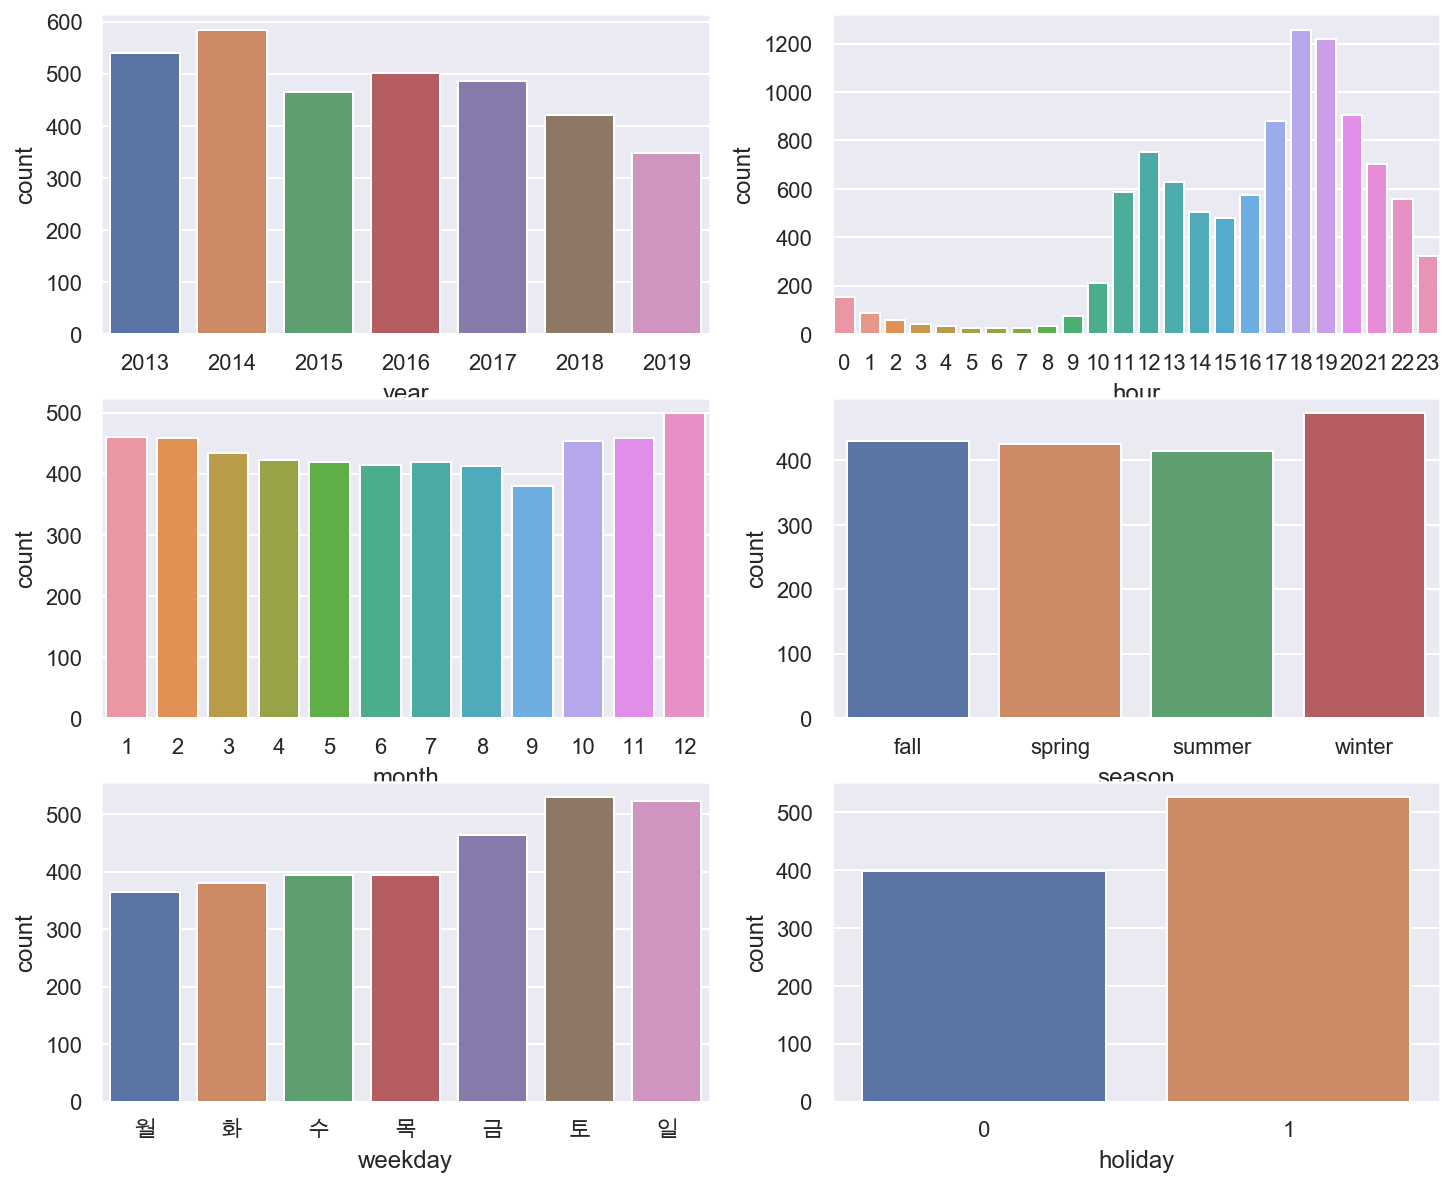

In [44]:
fig = plt.figure(figsize=[12, 10])
ax1 = fig.add_subplot(3, 2, 1)
ax1 = sns.barplot(x='year', y='count',
                  data=df_2013.groupby('year')['count'].mean().reset_index())

ax2 = fig.add_subplot(3, 2, 2)
ax2 = sns.barplot(x='hour', y='count',
                  data=df_2016.groupby('hour')['count'].mean().reset_index())

ax3 = fig.add_subplot(3, 2, 3)
ax3 = sns.barplot(x='month', y='count',
                  data=df_2016.groupby('month')['count'].mean().reset_index())

ax4 = fig.add_subplot(3, 2, 4)
ax4 = sns.barplot(x='season', y='count',
                  data=df_2016.groupby('season')['count'].mean().reset_index())

ax5 = fig.add_subplot(3, 2, 5)
ax5 = sns.barplot(x='weekday', y='count', order = ["월","화","수","목","금","토","일"],
                  data=df_2016.groupby('weekday')['count'].mean().reset_index())

ax6 = fig.add_subplot(3, 2, 6)
ax6 = sns.barplot(x='holiday', y='count',
                  data=df_2016.groupby('holiday')['count'].mean().reset_index())

In [45]:
# 1. 연도별 주문량 추이는 배달어플 이용자의 증가에 따라 통화량은 줄어든다
# 2. 시간대별 전체 주문량 / 점심, 저녁에 몰려있고 점심보다 저녁 주문량이 많음
# 3-4. 겨울철 주문량이 다른 계절 주문량보다 많다. 
# 5-6. 주말 주문량이 평일 주문량보다 많다.

### 2-2. 계절, 휴일, 요일, 업종에 따른 시간별 주문분포

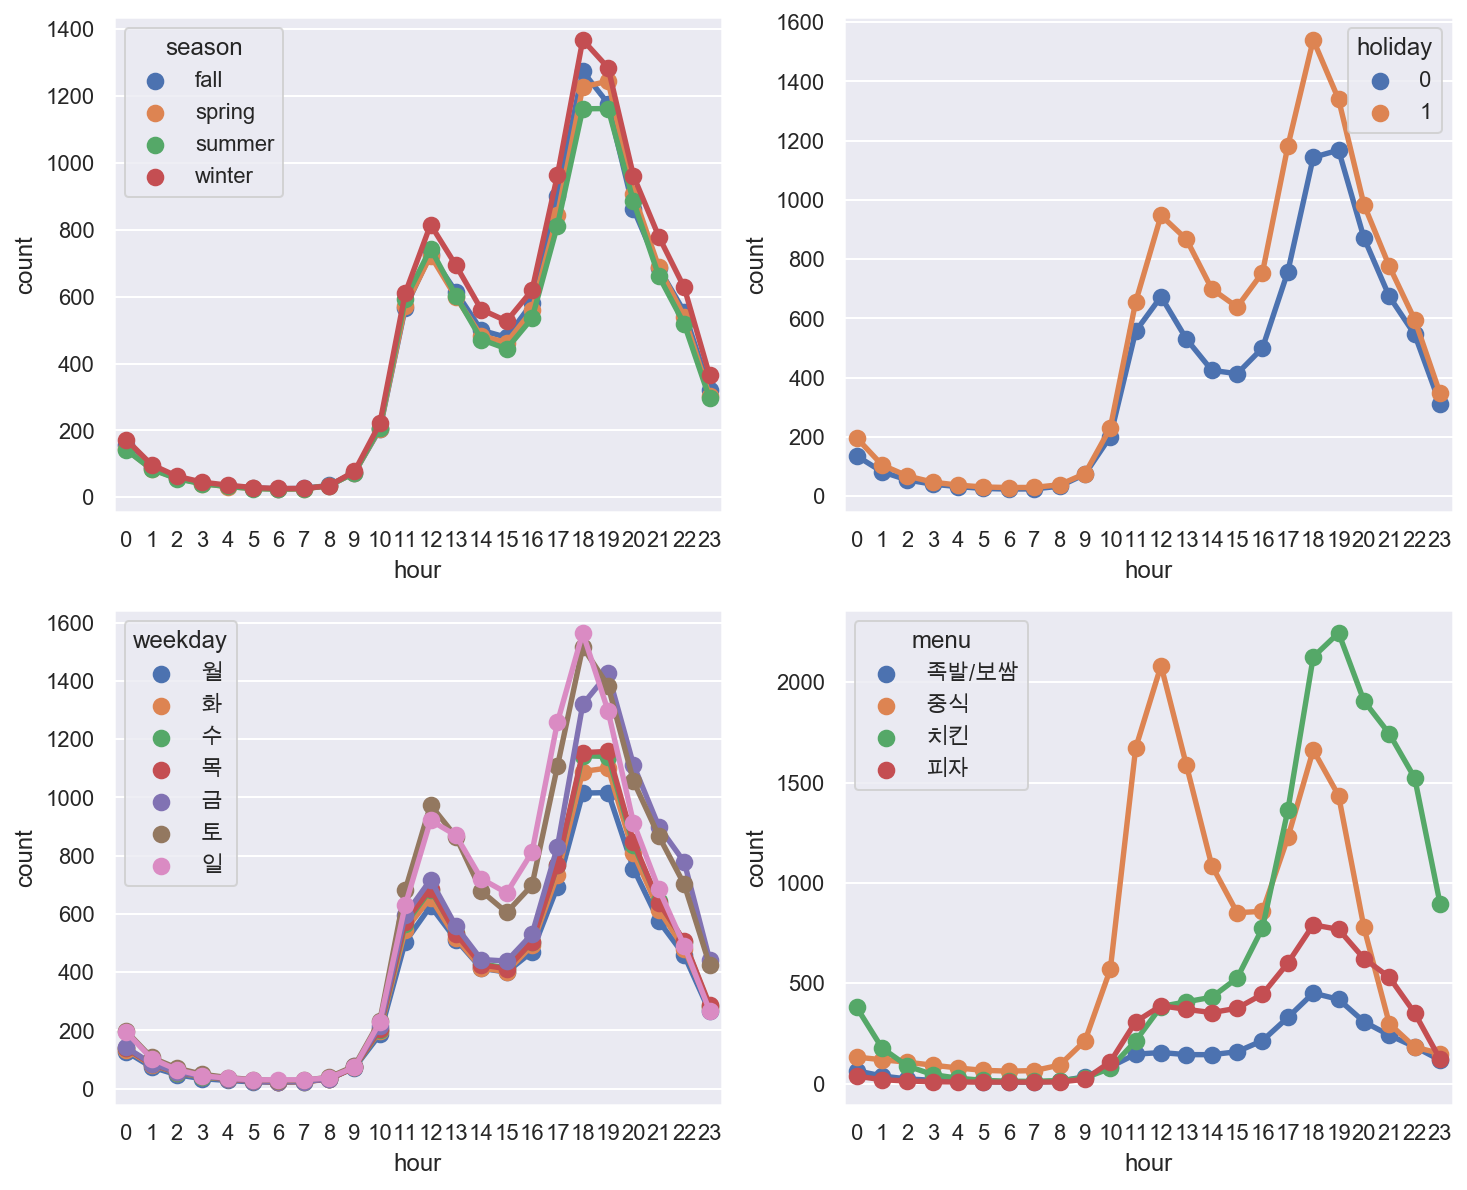

In [46]:
# 1. 시간과 계절에 따른 count
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax1 = sns.pointplot(x='hour', y='count', hue="season",
                    data=df_2016.groupby(['season', 'hour'])['count'].mean().reset_index())

# 2. 시간과 휴일에 따른 count
ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.pointplot(x='hour', y='count', hue="holiday",
                    data=df_2016.groupby(['holiday', 'hour'])['count'].mean().reset_index())

# 3. 시간과 요일에 따른 count
ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.pointplot(x='hour', y='count', hue="weekday", hue_order=['월', '화',
                                                                   '수', '목',
                                                                   '금', '토',
                                                                   "일"],
                    data=df_2016.groupby(['weekday', 'hour'])['count'].mean().reset_index())
# 4. 시간과 메뉴에 따른 count
ax4 = fig.add_subplot(2, 2, 4)
ax4 = sns.pointplot(x='hour', y='count', hue="menu",
                    data=df_2016.groupby(['menu', 'hour'])['count'].mean().reset_index())

### 2-3. 공휴일 특성별 주문분포

In [53]:
df_1 = df_2016.copy()
df_2 = df_2016.copy()

In [54]:
df_1.head()

,date,weekday,hour,menu,count,year,month,season,holiday,Unnamed: 0,datename
0,20161001,토,0,족발/보쌈,123.0,2016,10,fall,1,NaN,NaN
1,20161001,토,0,중식,165.0,2016,10,fall,1,NaN,NaN
2,20161001,토,0,치킨,791.0,2016,10,fall,1,NaN,NaN
3,20161001,토,0,피자,70.0,2016,10,fall,1,NaN,NaN
4,20161001,토,1,족발/보쌈,55.0,2016,10,fall,1,NaN,NaN


In [55]:
# 토, 일 datename => "주말"
# df_1은 추석, 설날을 제외한 공휴일과 겹치는 토, 일요일은 = > "주말" 로 ..
df_1.loc[df_1["weekday"].isin(["토","일"]) & df_1["datename"].isnull(), "datename"] = "주말"
df_1.loc[df_1["weekday"].isin(["토","일"]) & ~df_1["datename"].isin(["설날", "추석"]), "datename"] = "주말"
df_1[df_1["date"]=="20161009"]

,date,weekday,hour,menu,count,year,month,season,holiday,Unnamed: 0,datename
750,20161009,일,0,족발/보쌈,114.0,2016,10,fall,1,62.0,주말
751,20161009,일,0,중식,211.0,2016,10,fall,1,62.0,주말
752,20161009,일,0,치킨,777.0,2016,10,fall,1,62.0,주말
753,20161009,일,0,피자,65.0,2016,10,fall,1,62.0,주말
754,20161009,일,1,족발/보쌈,50.0,2016,10,fall,1,62.0,주말
...,...,...,...,...,...,...,...,...,...,...,...
838,20161009,일,22,피자,480.0,2016,10,fall,1,62.0,주말
839,20161009,일,23,족발/보쌈,101.0,2016,10,fall,1,62.0,주말
840,20161009,일,23,중식,210.0,2016,10,fall,1,62.0,주말
841,20161009,일,23,치킨,995.0,2016,10,fall,1,62.0,주말


In [56]:
# df_2는 공휴일이면서 토, 일요일과 겹치면 datename => "국경일이름"
df_2.loc[df_2["weekday"].isin(["토","일"]) & df_2["datename"].isnull(), "datename"] = "주말"

In [57]:
df_2[df_2["date"]=="20161009"]

,date,weekday,hour,menu,count,year,month,season,holiday,Unnamed: 0,datename
750,20161009,일,0,족발/보쌈,114.0,2016,10,fall,1,62.0,한글날
751,20161009,일,0,중식,211.0,2016,10,fall,1,62.0,한글날
752,20161009,일,0,치킨,777.0,2016,10,fall,1,62.0,한글날
753,20161009,일,0,피자,65.0,2016,10,fall,1,62.0,한글날
754,20161009,일,1,족발/보쌈,50.0,2016,10,fall,1,62.0,한글날
...,...,...,...,...,...,...,...,...,...,...,...
838,20161009,일,22,피자,480.0,2016,10,fall,1,62.0,한글날
839,20161009,일,23,족발/보쌈,101.0,2016,10,fall,1,62.0,한글날
840,20161009,일,23,중식,210.0,2016,10,fall,1,62.0,한글날
841,20161009,일,23,치킨,995.0,2016,10,fall,1,62.0,한글날


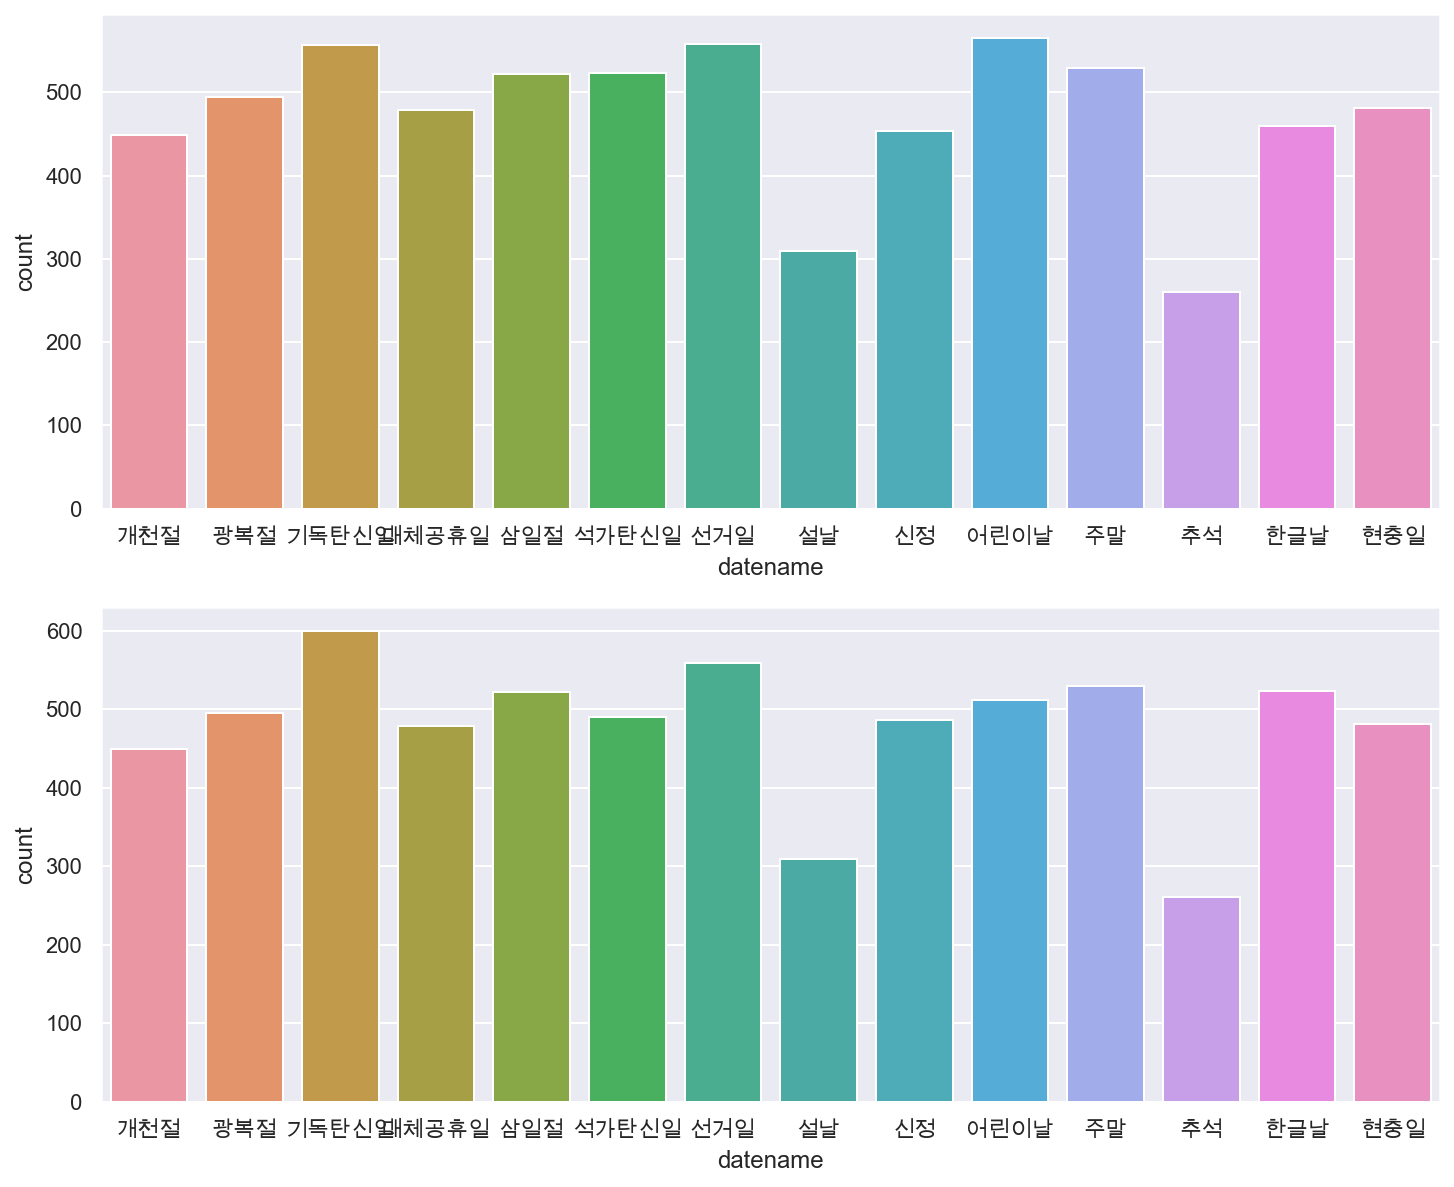

In [58]:
# 휴일 주문건수 확인
fig = plt.figure(figsize=(12, 10))

# 2. 어떤 휴일에 주문량이 가장 많을까? 
ax2 = fig.add_subplot(2, 1, 1)
ax2 = sns.barplot(x='datename', y='count',
                    data=df_1[df_1["holiday"]==1].groupby(["datename"])['count'].mean().reset_index())

ax2 = fig.add_subplot(2, 1, 2)
ax2 = sns.barplot(x='datename', y='count',
                    data=df_2[df_2["holiday"]==1].groupby(["datename"])['count'].mean().reset_index())

In [59]:
# 기독탄신일, 어린이날 등은 주말보다 공휴일에 의미를 두고, 그 외의 공휴일은 주말이랑 겹치면 주말일뿐이다 ㅋㅋ
# 설날, 추석은 주문량이 실제로 떨어진다
# 공휴일의 성격이 주문량에 영향을 끼치므로 공휴일이면서 주말인 경우 공휴일로 카운팅

In [60]:
data=df_1.pivot_table(index = ["datename"], values="count").sort_values(by="count")
data.tail()

,count
datename,
석가탄신일,523.465608
주말,529.156142
기독탄신일,556.465608
선거일,558.313830
어린이날,565.354167


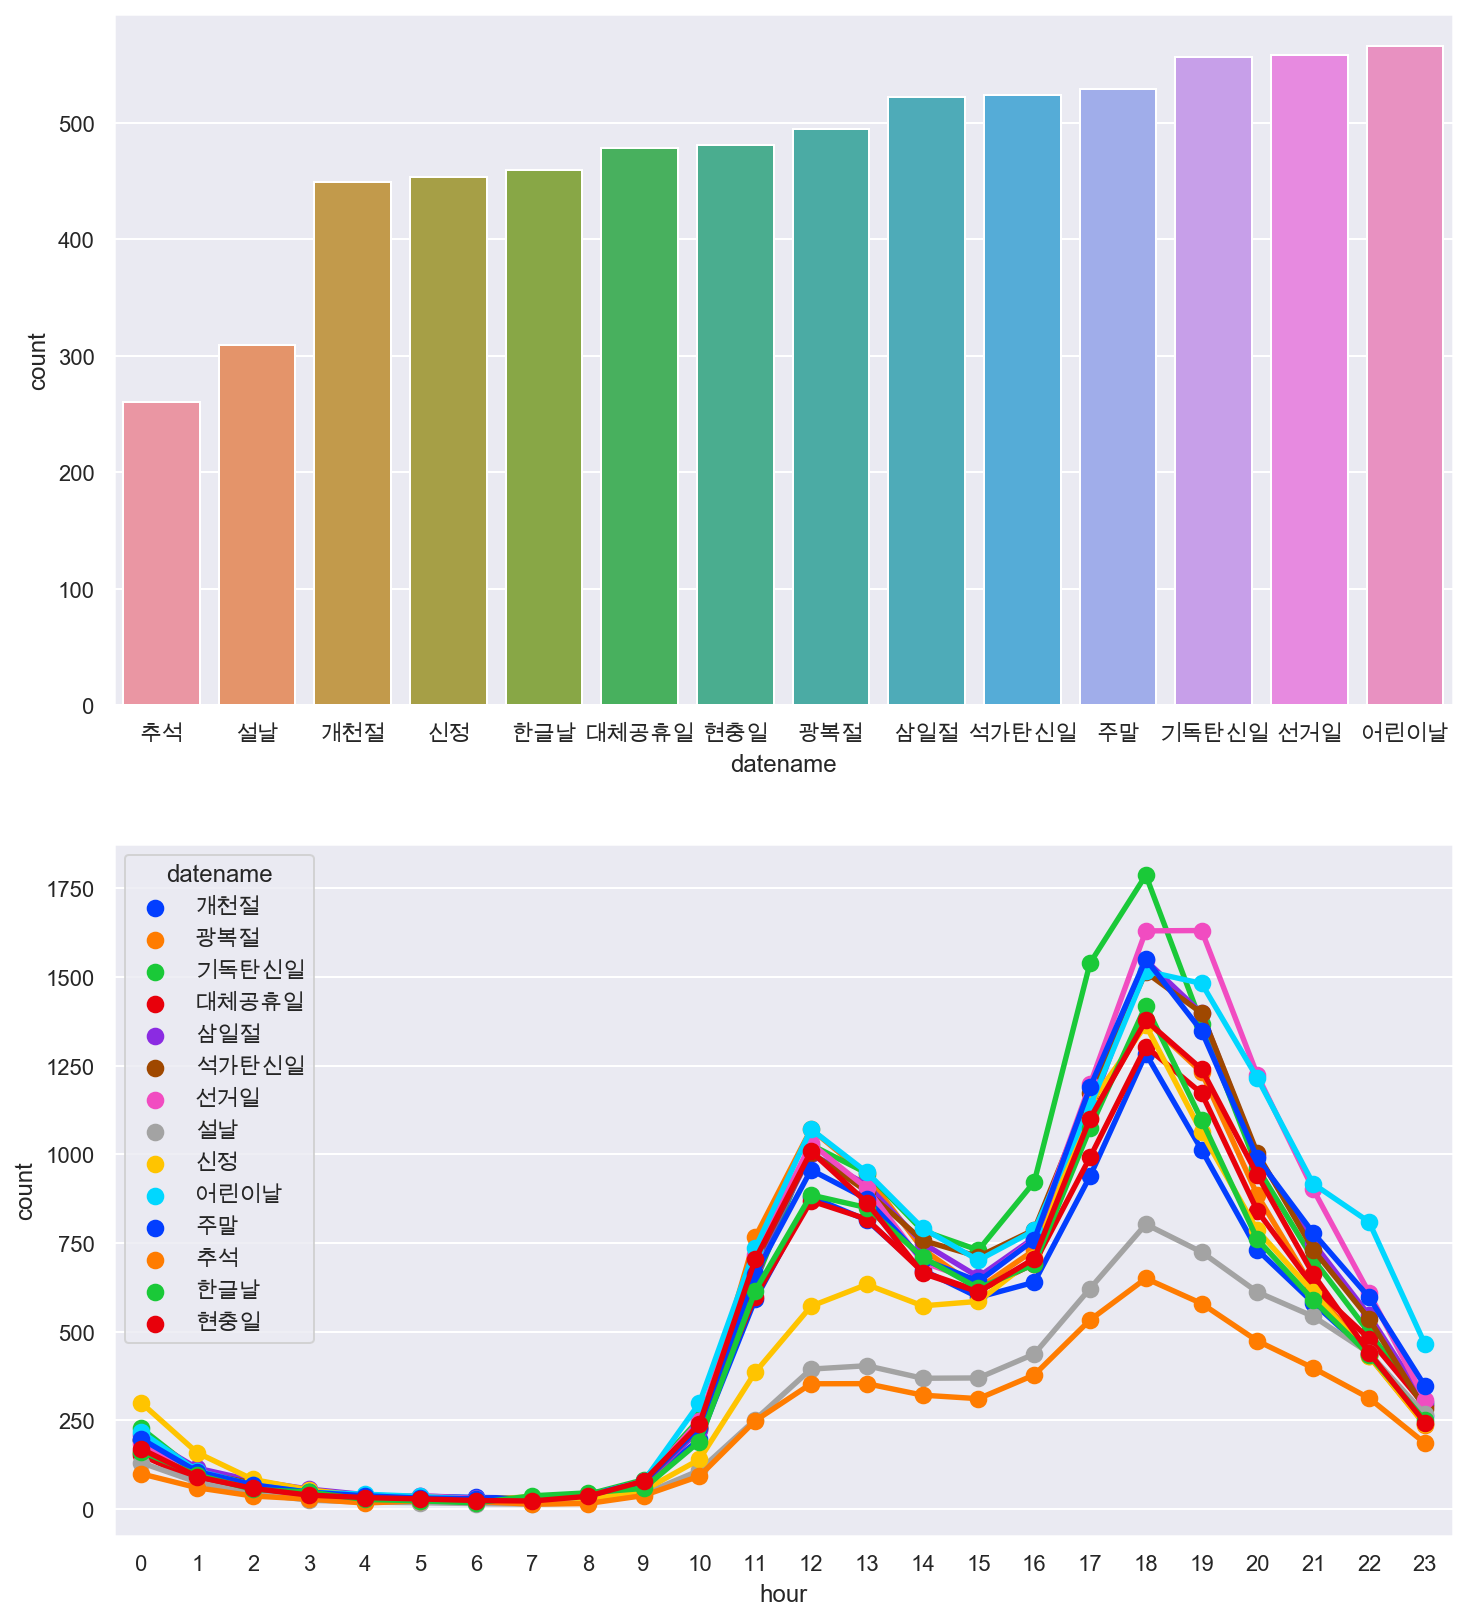

In [61]:
fig = plt.figure(figsize=(12, 14))

ax2 = fig.add_subplot(2, 1, 1)
ax2 = sns.barplot(x=data.index, y='count',
                    data=data)

ax3 = fig.add_subplot(2, 1, 2)
ax3 = sns.pointplot(x='hour', y='count', hue="datename", palette="bright",
                    data=df_1.groupby(['datename', 'hour'])['count'].mean().reset_index())


In [62]:
# 주말보다 더 많이 배달주문하는 공휴일 > 성탄절, 선거일, 어린이날 
# 선거일 18시 이후 주문량 계속 높음 > 개표방송
# 어린이날 주문량 계속 높음
# 신정 00시 주문량 높음 > 연말의 영향
# 보통 주말에 비해 점심 주문량이 높은 편

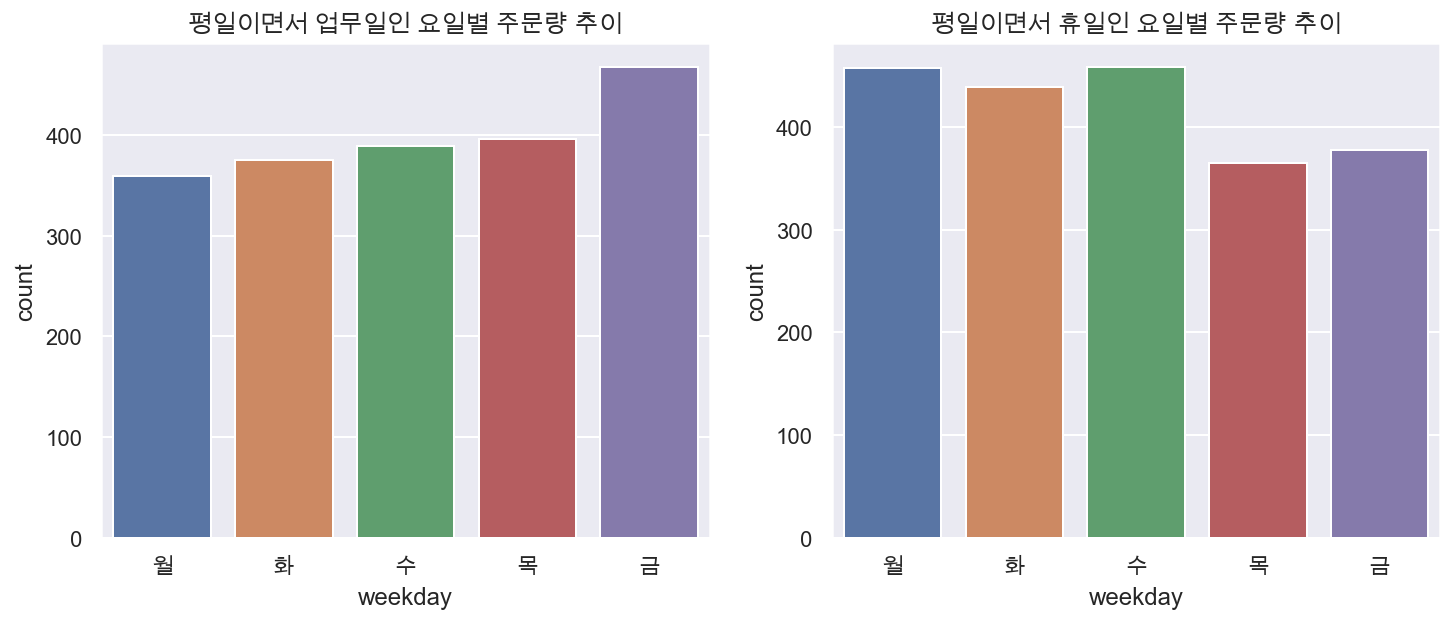

In [63]:
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(2, 2, 1, title ="평일이면서 업무일인 요일별 주문량 추이")
ax1 = sns.barplot(x='weekday', y='count', order = ["월", "화", "수", "목", "금"], 
                     data=df_1[df_1["holiday"]==0].groupby(['weekday'])['count'].mean().reset_index())

ax2 = fig.add_subplot(2, 2, 2, title = "평일이면서 휴일인 요일별 주문량 추이")
ax2 = sns.barplot(x='weekday', y='count', order = ["월", "화", "수", "목", "금"], 
                     data=df_1[df_1["holiday"]==1].groupby(['weekday'])['count'].mean().reset_index())

# 2. 업종기준 EDA

### 1. 데이터 로드 및 확인

In [10]:
data = pd.read_csv("./skt_data_2016-2019.csv")
# data.drop(columns=["Unnamed: 0"], axis=1, inplace=True) 
data.head()

,일자,요일,시간대,업종,시도,시군구,읍면동,통화건수
0,20161001,토,0,족발/보쌈,서울특별시,강남구,역삼동,5.0
1,20161001,토,0,족발/보쌈,서울특별시,강남구,일원동,5.0
2,20161001,토,0,족발/보쌈,서울특별시,강동구,성내동,5.0
3,20161001,토,0,족발/보쌈,서울특별시,강동구,천호동,5.0
4,20161001,토,0,족발/보쌈,서울특별시,강북구,미아동,5.0


In [130]:
data.tail()

,일자,요일,시간대,업종,시도,시군구,읍면동,통화건수
4624225,20190930,월,23,피자,서울특별시,서초구,양재동,5.0
4624226,20190930,월,23,피자,서울특별시,성북구,동선동2가,5.0
4624227,20190930,월,23,피자,서울특별시,송파구,가락동,5.0
4624228,20190930,월,23,피자,서울특별시,영등포구,영등포동5가,5.0
4624229,20190930,월,23,피자,서울특별시,중랑구,면목동,5.0


In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4624230 entries, 0 to 4624229
Data columns (total 8 columns):
 #   Column  Dtype  
---  ------  -----  
 0   일자      int64  
 1   요일      object 
 2   시간대     int64  
 3   업종      object 
 4   시도      object 
 5   시군구     object 
 6   읍면동     object 
 7   통화건수    float64
dtypes: float64(1), int64(2), object(5)
memory usage: 282.2+ MB


In [133]:
data.isnull().sum()

일자      0
요일      0
시간대     0
업종      0
시도      0
시군구     0
읍면동     0
통화건수    0
dtype: int64

### 2. 날짜/업종별 주문량

In [134]:
date_order = data.pivot_table("통화건수", "일자", "업종").round(1).reset_index()

In [135]:
date_order["일자"] = date_order["일자"].astype("str")
date_order["일자"] = pd.to_datetime(date_order["일자"])

#### 2-1. 2016.10.01.~2019.09.30. 총 3년간 데이터 분석

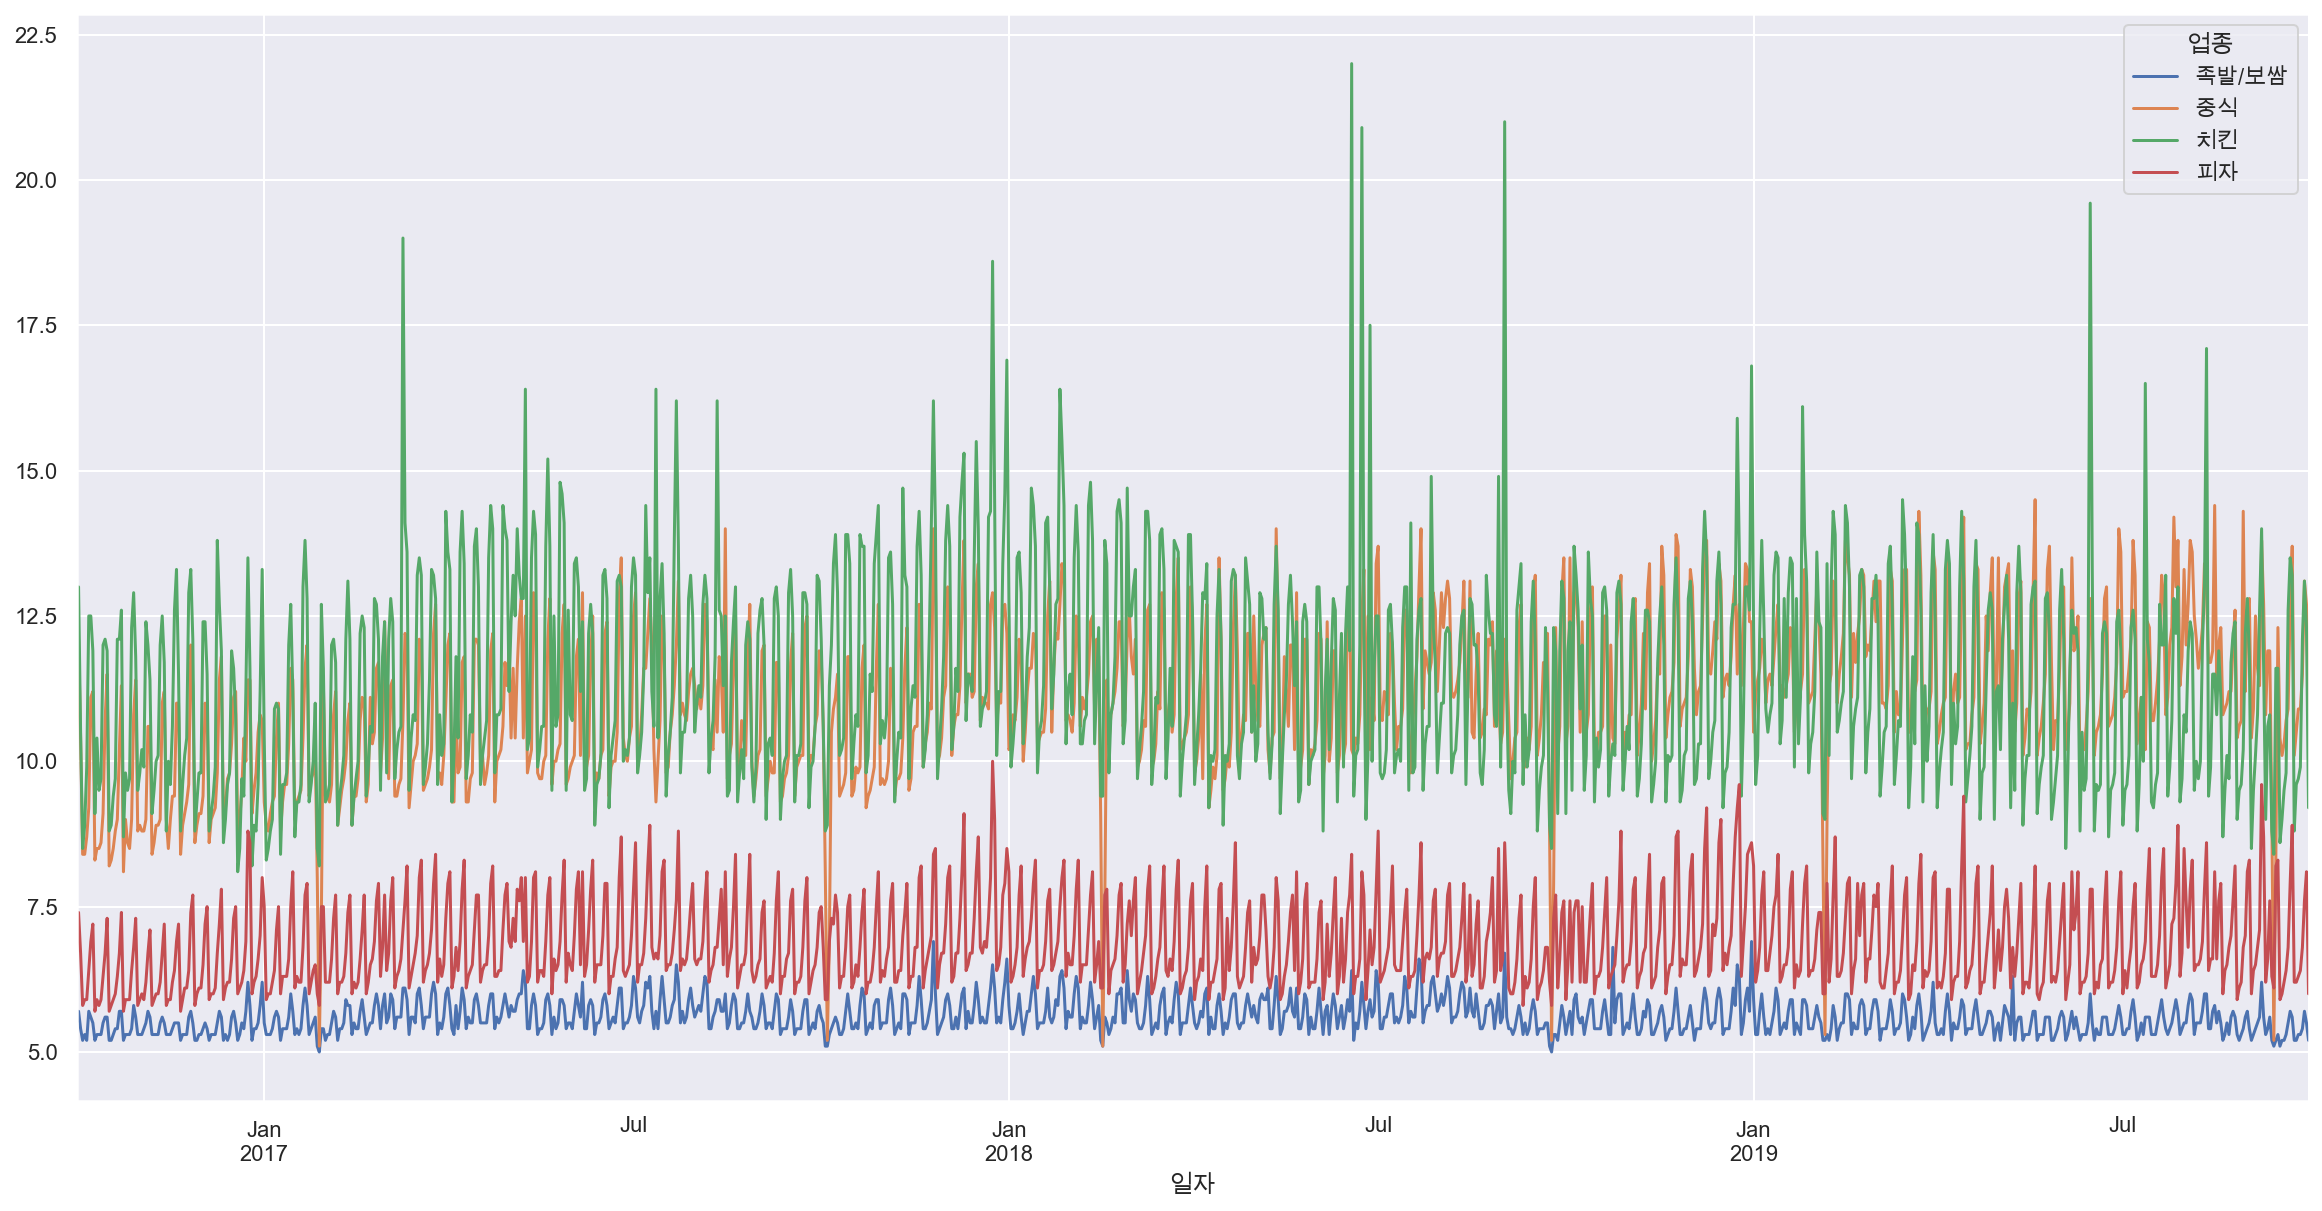

In [136]:
date_order.plot.line(x="일자",figsize=(20,10))
plt.grid("white")
plt.show()

#### 2-2. 월별 특성분석

In [137]:
date_order = date_order.set_index("일자")
monthly_order = date_order.resample('MS').mean().round(1).reset_index()

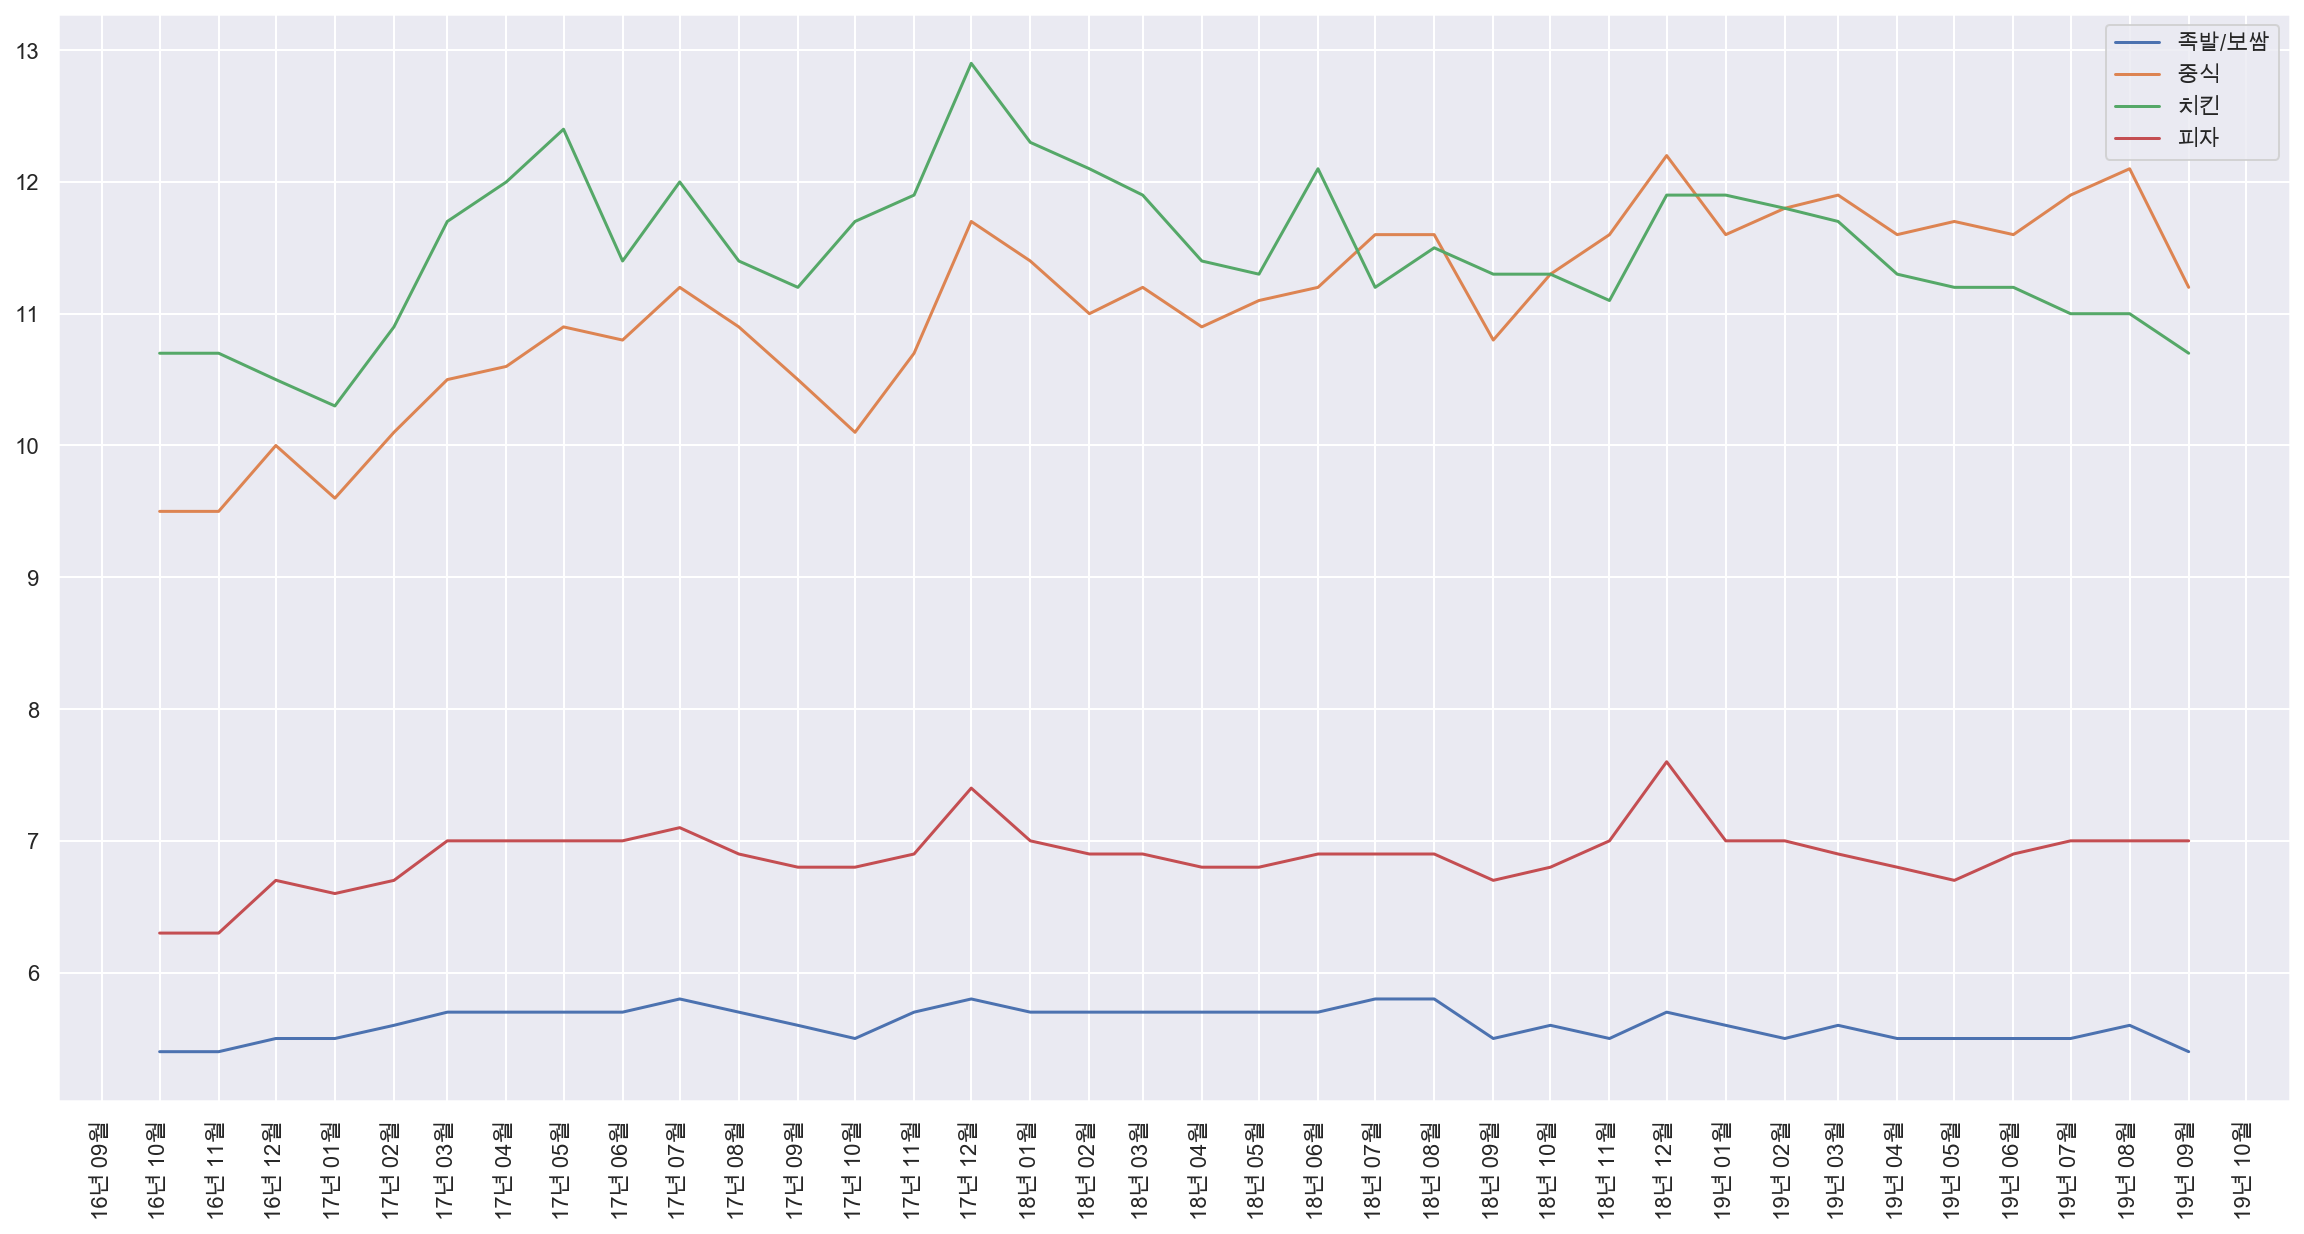

In [140]:
months = MonthLocator()  # every month
fig, ax = plt.subplots(figsize=(20,10))

ax.plot_date(monthly_order["일자"] , \
             monthly_order[["족발/보쌈","중식","치킨","피자"]], '-')      # x: datetime, y: random % values
ax.xaxis.set_major_locator(months)   # define xtick major location
monFmt = DateFormatter('%y년 %m월')      # define xtick string format
ax.xaxis.set_major_locator(months)   # apply xtick location
ax.xaxis.set_major_formatter(monFmt) # apply xtick label
plt.xticks(rotation=90)
plt.legend(monthly_order[["족발/보쌈","중식","치킨","피자"]])
plt.show()

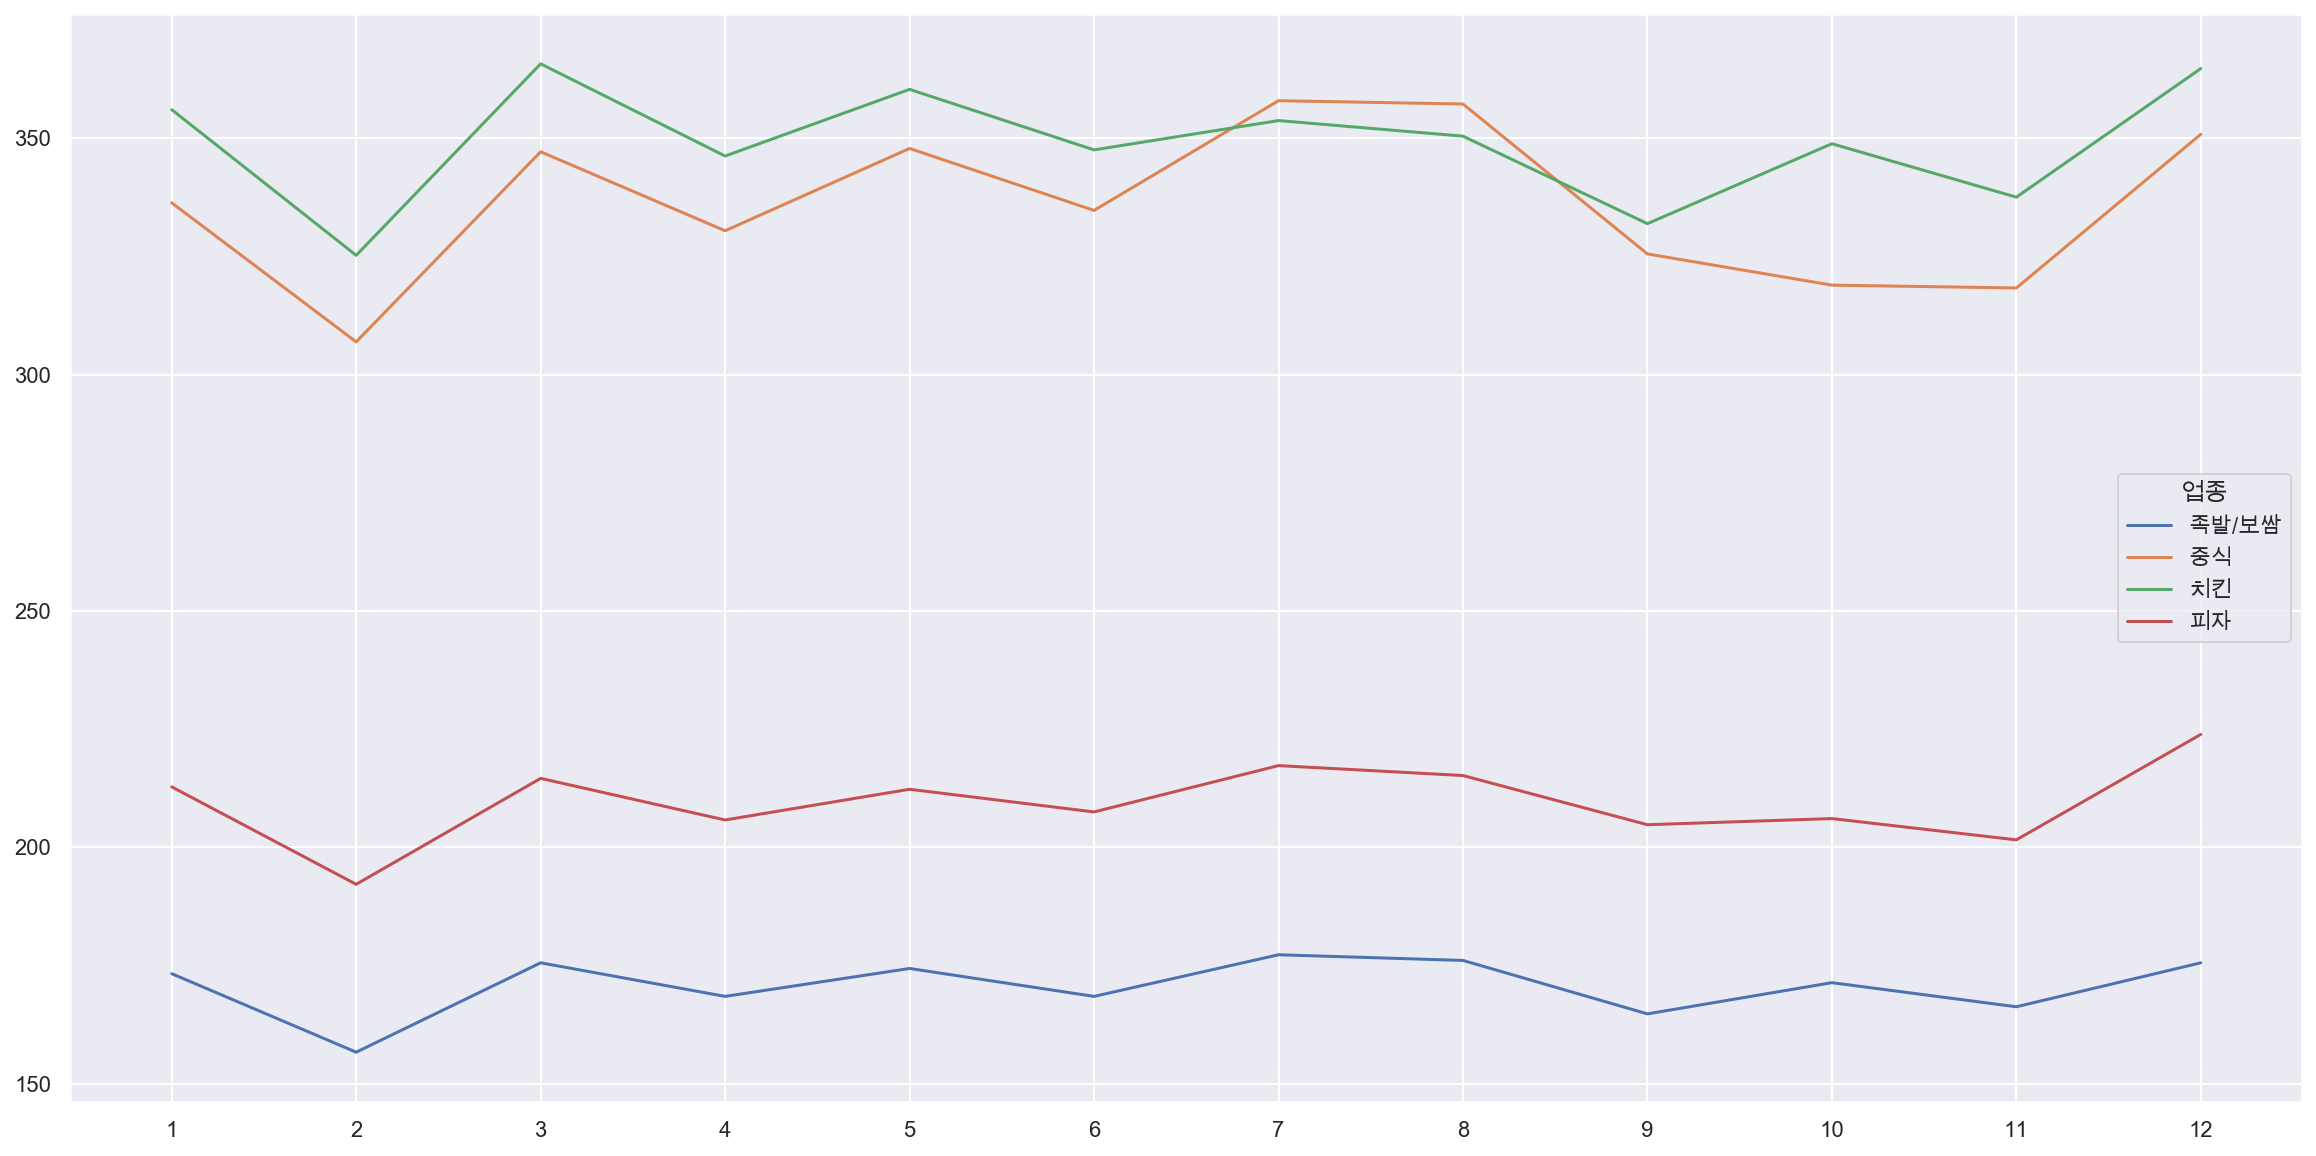

In [141]:
monthly_order_2 = date_order.resample('M').sum().reset_index()
monthly_order_2["일자"] = monthly_order_2["일자"].dt.month
monthly_order_2 = monthly_order_2.groupby("일자").mean().round(1)
monthly_order_2.plot.line(figsize=(20,10))
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel(None)
plt.show()

In [142]:
col = ["족발/보쌈", "중식", "치킨", "피자"]
monthly_order_2_norm = ((monthly_order_2[col]-monthly_order_2[col].min()) / (monthly_order_2[col].max()-monthly_order_2[col].min())).round(3)
monthly_order_2_norm.head()

업종,족발/보쌈,중식,치킨,피자
일자,,,,
1,0.806,0.576,0.760,0.650
2,0.000,0.000,0.000,0.000
3,0.917,0.788,1.000,0.707
4,0.573,0.461,0.519,0.429
5,0.859,0.802,0.867,0.634


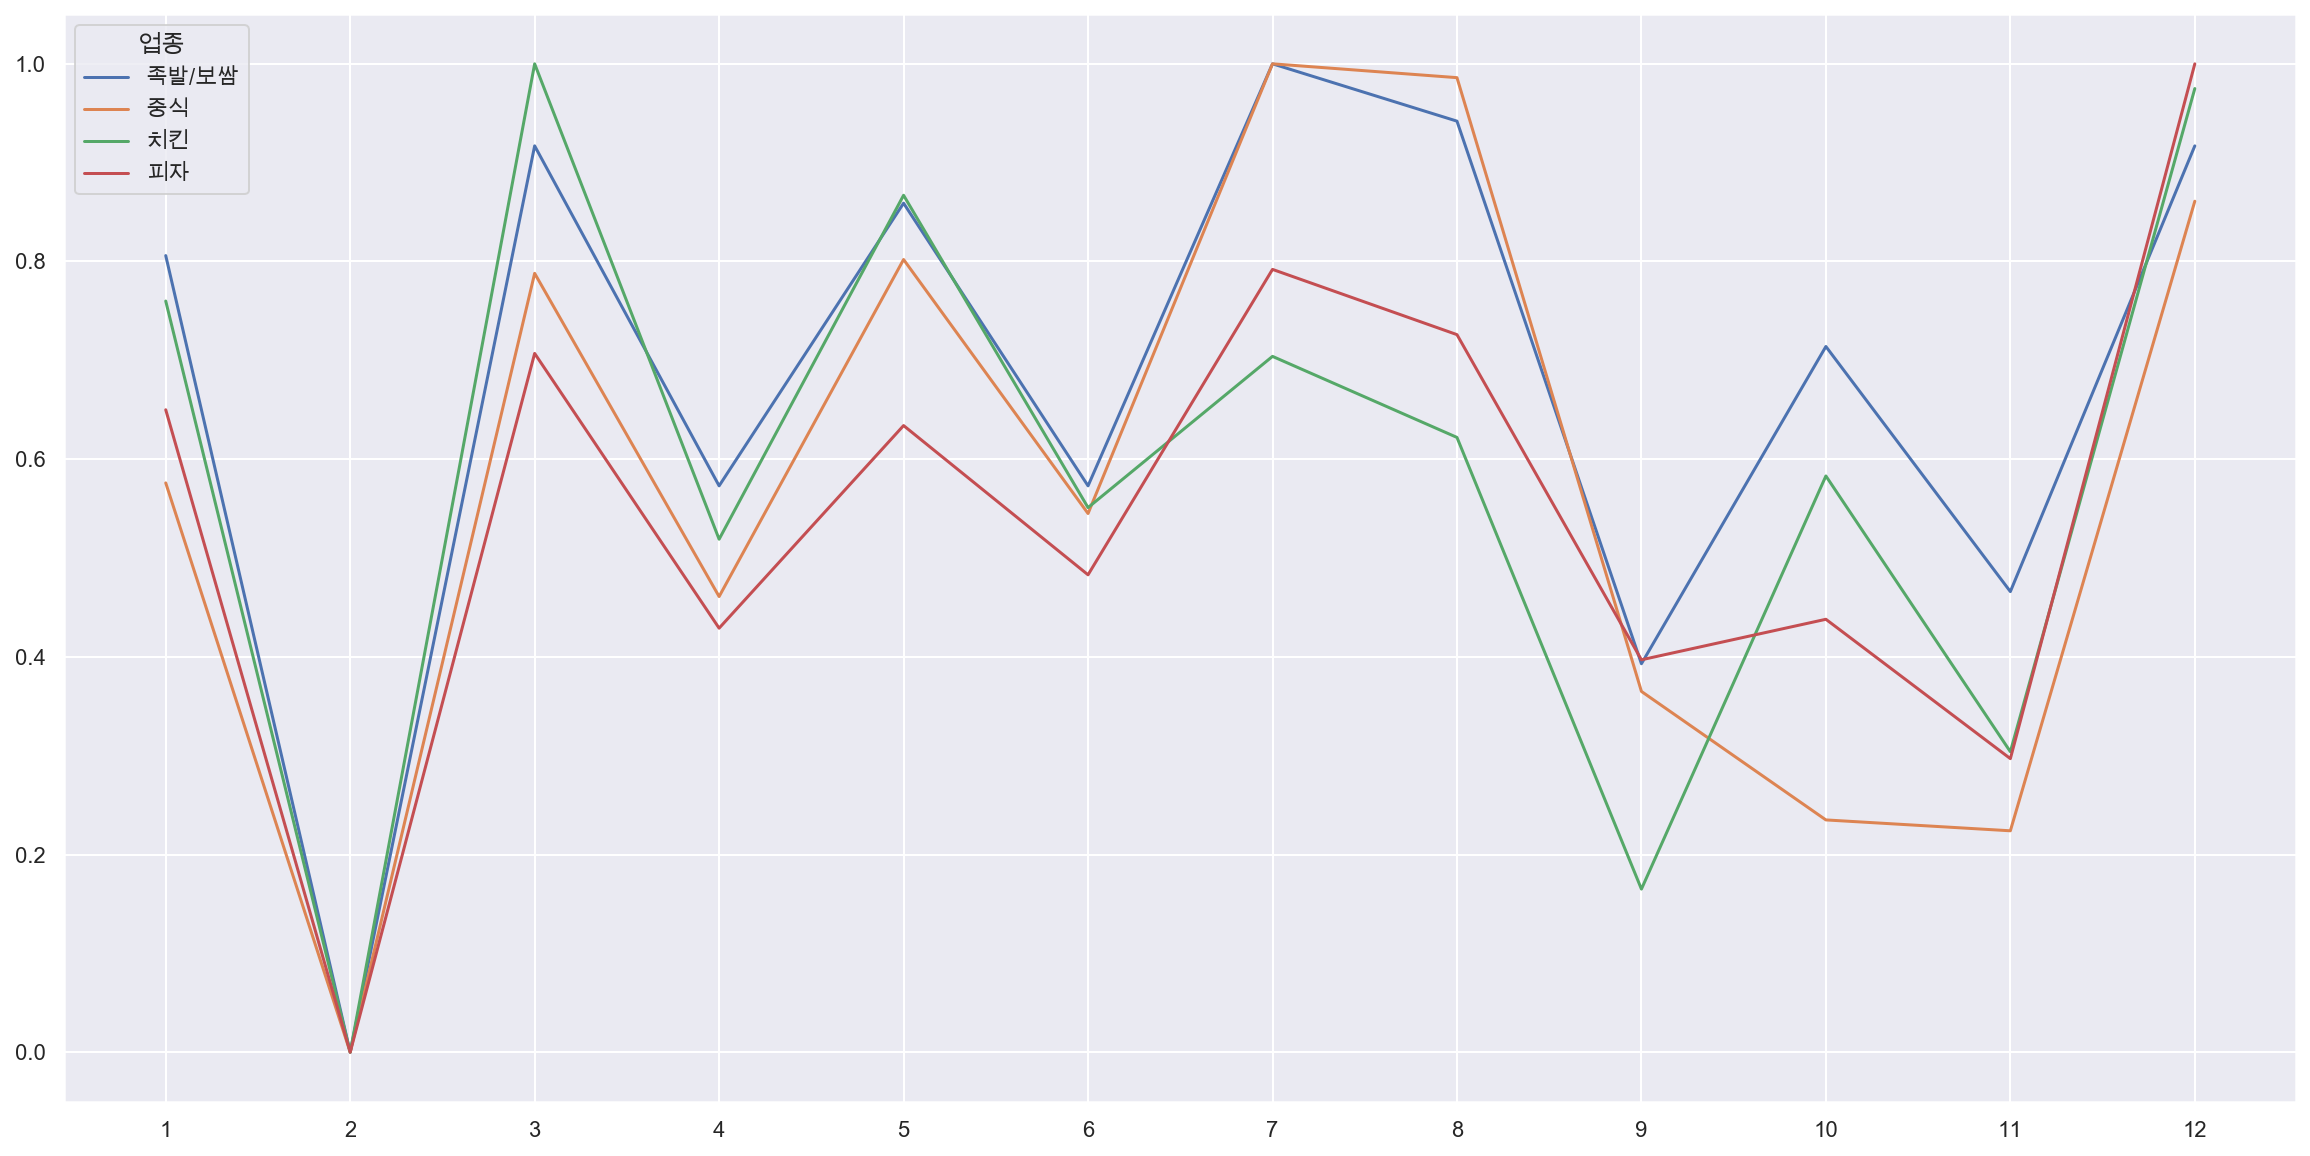

In [143]:
monthly_order_2_norm.plot.line(figsize=(20,10))
plt.xlabel(None)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.show()

#### 2-2. 일별특성분석

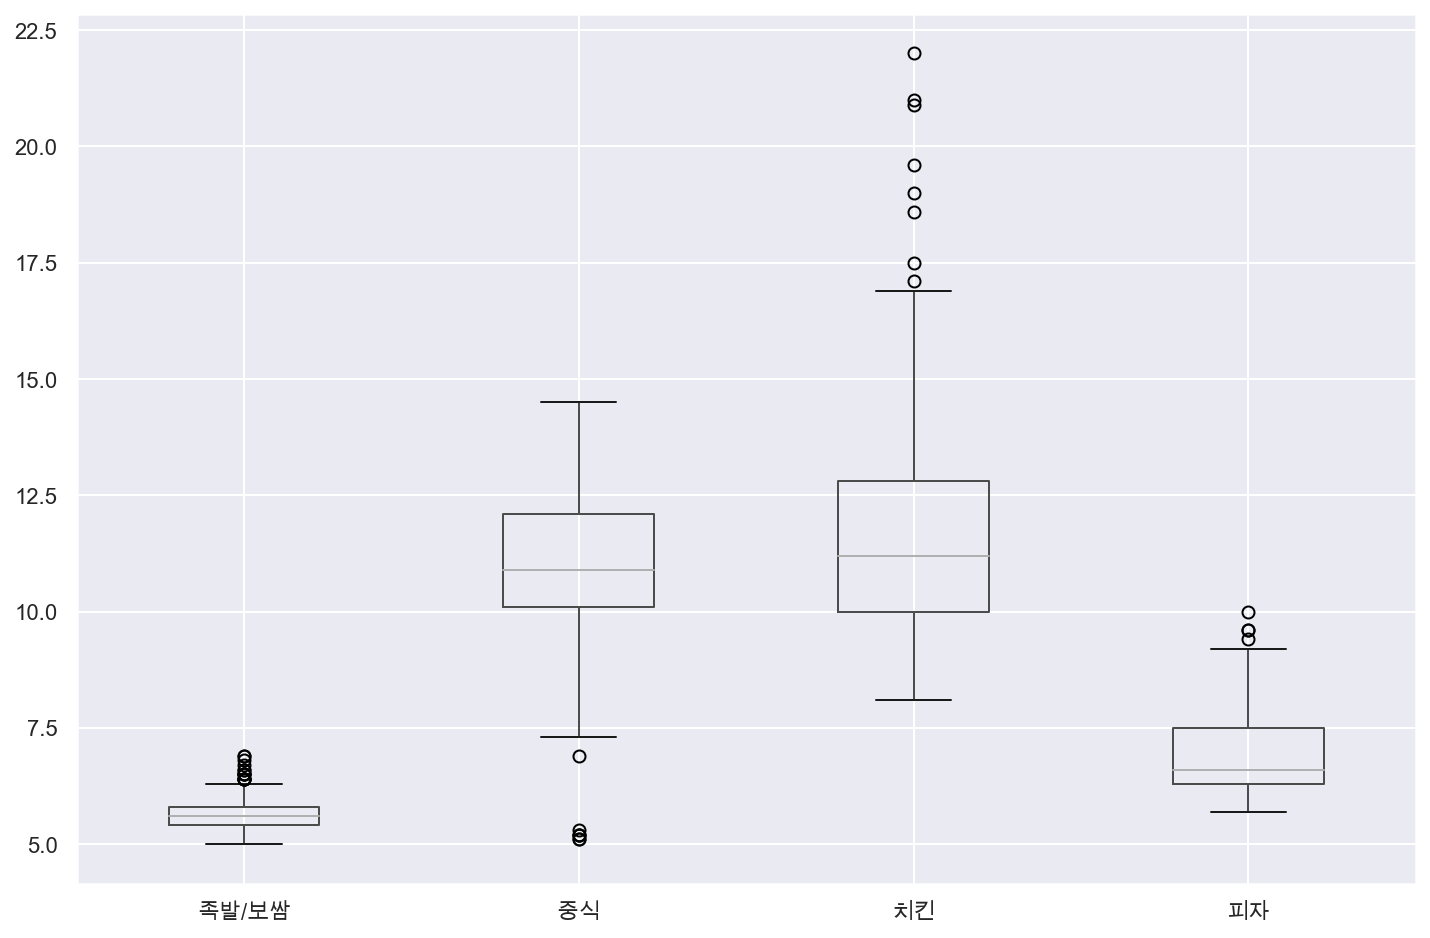

In [144]:
date_order.boxplot(figsize=(12,8));

In [145]:
# iqr 구하기
def iqr(arr):
    iqr = (np.percentile(arr, 75) - np.percentile(arr, 25)).round(1)
    upper_fence = (np.percentile(arr, 75) + iqr*1.5).round(1)
    lower_fence = (np.percentile(arr, 25) - iqr*1.5).round(1)
    return "iqr: {}, upper_fence: {}, lower_fence: {}".format(iqr, upper_fence, lower_fence)

iqr(date_order["족발/보쌈"]), iqr(date_order["중식"]), iqr(date_order["치킨"]), iqr(date_order["피자"])

('iqr: 0.4, upper_fence: 6.4, lower_fence: 4.8',
 'iqr: 2.0, upper_fence: 15.1, lower_fence: 7.1',
 'iqr: 2.8, upper_fence: 17.0, lower_fence: 5.8',
 'iqr: 1.2, upper_fence: 9.3, lower_fence: 4.5')

In [147]:
date_order[date_order["족발/보쌈"] > 6.4]

업종,족발/보쌈,중식,치킨,피자
일자,,,,
2017-07-22,6.5,12.0,16.2,7.6
2017-11-25,6.9,14.0,16.2,8.4
2017-12-24,6.5,12.9,18.6,10.0
2017-12-31,6.6,12.2,16.9,8.5
2018-07-21,6.6,13.0,12.6,7.7
2018-07-22,6.5,14.0,12.8,8.6
2018-09-01,6.7,12.1,21.0,8.6
2018-10-24,6.8,10.4,10.3,6.4
2018-12-24,6.5,11.5,15.9,9.2


In [148]:
date_order[date_order["중식"] < 7.1]

업종,족발/보쌈,중식,치킨,피자
일자,,,,
2017-01-28,5.0,5.1,8.2,5.8
2017-10-04,5.1,5.2,8.9,5.9
2017-10-05,5.3,6.9,11.3,6.9
2018-02-16,5.1,5.1,9.4,6.1
2018-09-24,5.0,5.2,8.5,5.8
2019-02-05,5.2,5.3,9.0,6.0
2019-09-13,5.1,5.2,8.4,6.1


In [149]:
date_order[date_order["치킨"] > 17.0]

업종,족발/보쌈,중식,치킨,피자
일자,,,,
2017-03-10,6.1,10.7,19.0,7.1
2017-12-24,6.5,12.9,18.6,10.0
2018-06-18,6.4,10.2,22.0,8.4
2018-06-23,6.2,12.5,20.9,8.1
2018-06-27,5.9,10.2,17.5,7.1
2018-09-01,6.7,12.1,21.0,8.6
2019-06-15,6.0,12.8,19.6,7.8
2019-08-11,6.0,12.9,17.1,8.6


In [150]:
date_order[date_order["피자"] > 9.3]

업종,족발/보쌈,중식,치킨,피자
일자,,,,
2017-12-24,6.5,12.9,18.6,10.0
2018-12-25,6.3,12.7,13.6,9.6
2019-04-14,5.8,14.2,13.1,9.4
2019-09-07,6.2,13.8,14.0,9.6


#### 2-3. 요일별 특성분석 

In [151]:
day_order = data.pivot_table("통화건수", "요일", "업종").round(1)
day_order_sort = pd.DataFrame(columns=["요일", "족발/보쌈", "중식", "치킨", "피자"])

day_order_sort.loc[0] = day_order.loc["월"]
day_order_sort.loc[1] = day_order.loc["화"]
day_order_sort.loc[2] = day_order.loc["수"]
day_order_sort.loc[3] = day_order.loc["목"]
day_order_sort.loc[4] = day_order.loc["금"]
day_order_sort.loc[5] = day_order.loc["토"]
day_order_sort.loc[6] = day_order.loc["일"]
day_order_sort["요일"] = ["월", "화", "수", "목", "금", "토", "일"]
day_order_sort.set_index("요일")

,족발/보쌈,중식,치킨,피자
요일,,,,
월,5.4,10.1,9.9,6.3
화,5.5,10.3,10.3,6.4
수,5.5,10.5,10.6,6.5
목,5.5,10.5,10.6,6.5
금,5.7,10.8,13.0,6.9
토,6.0,12.2,13.4,7.6
일,5.8,12.3,12.8,8.0


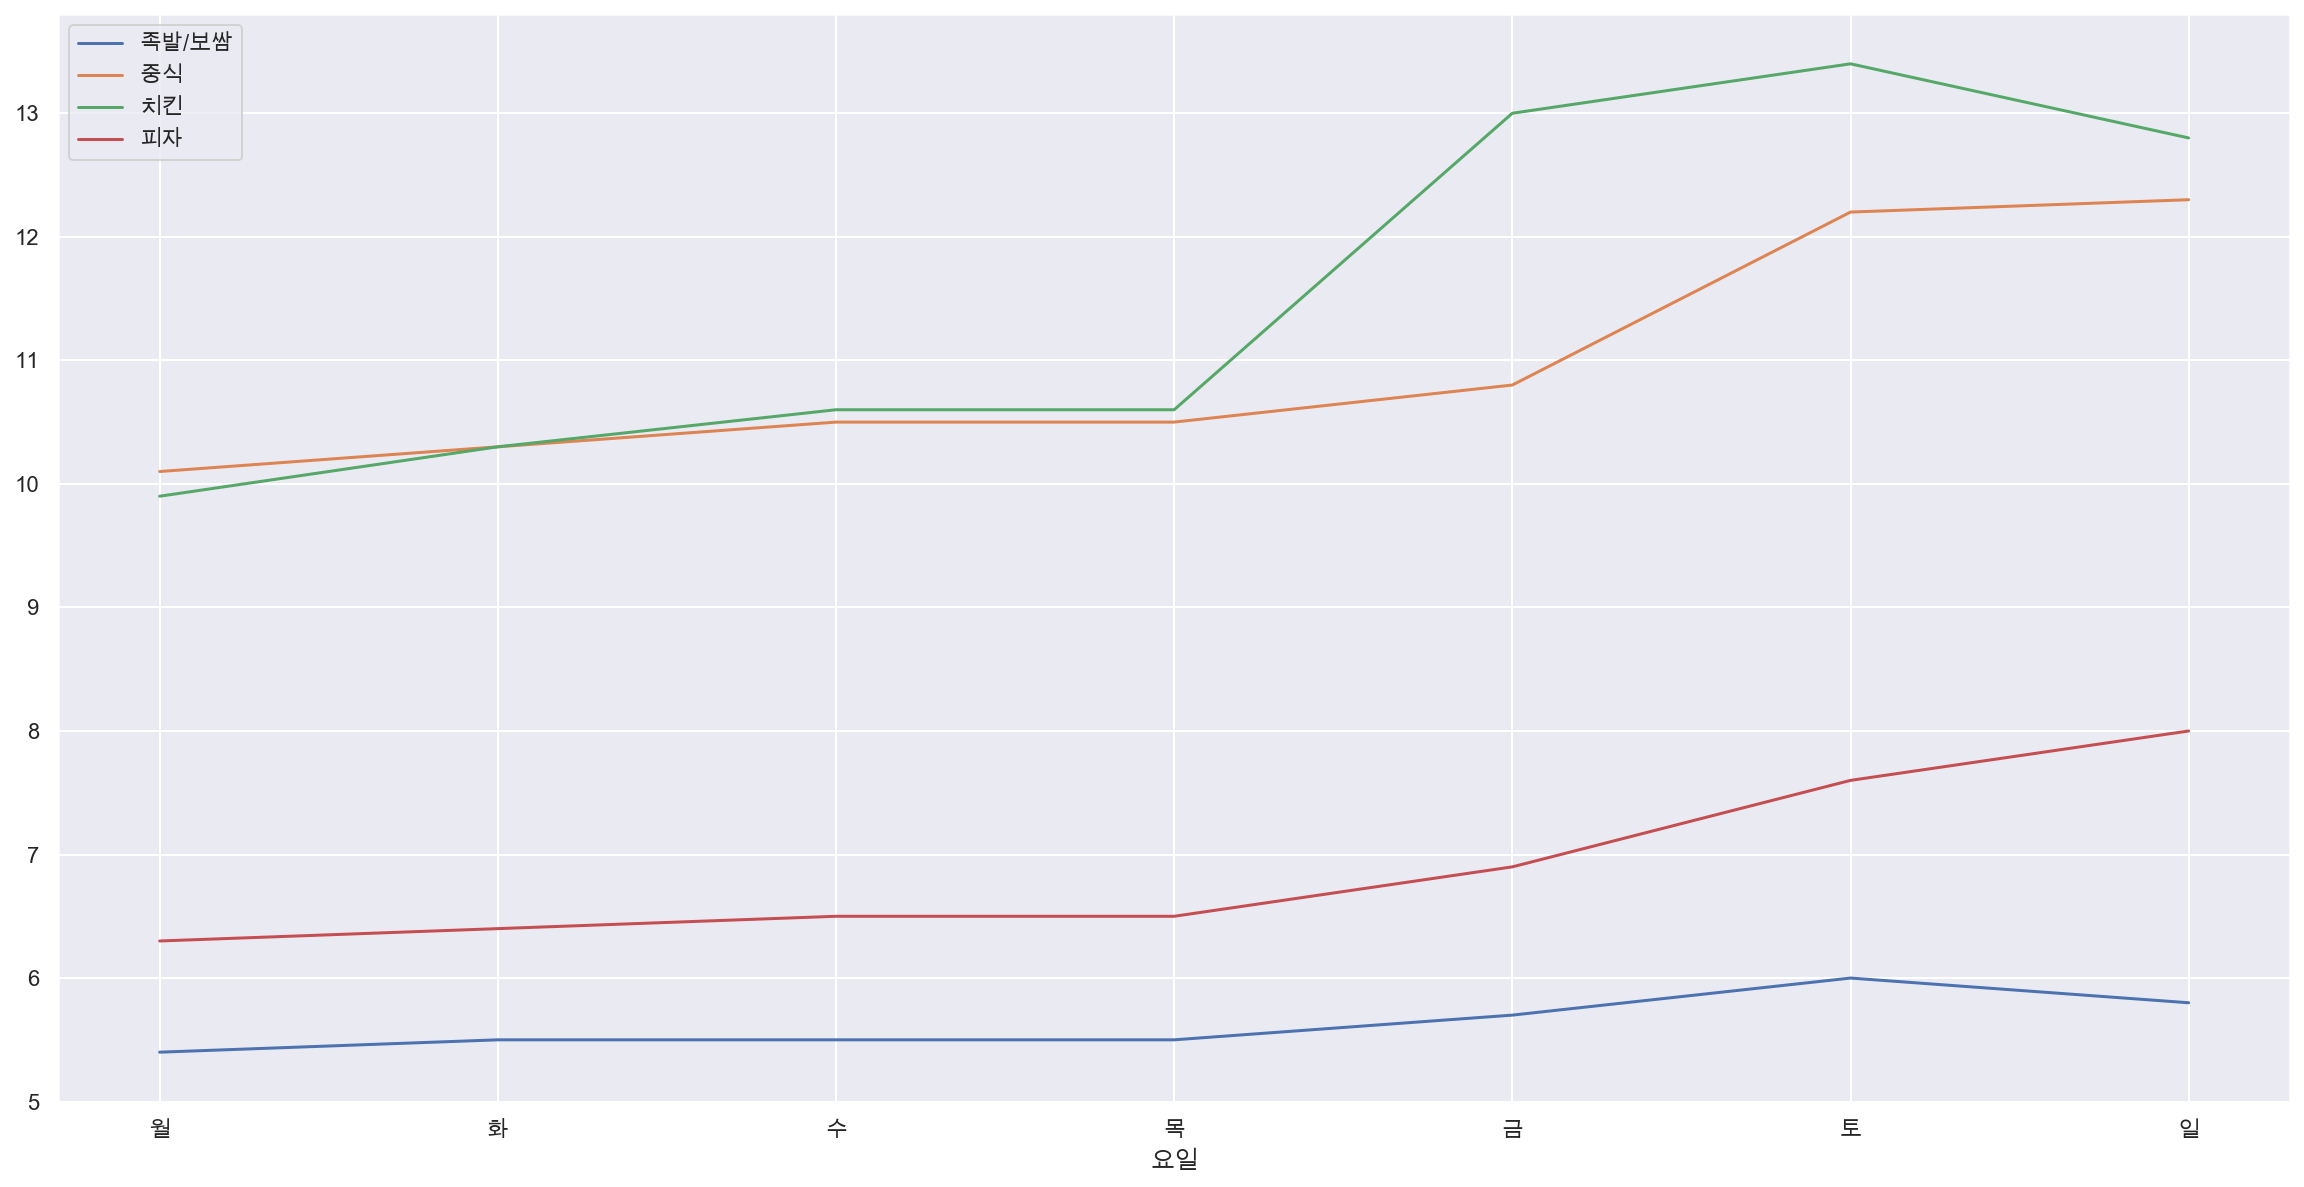

In [152]:
day_order_sort.plot.line(x="요일", figsize=(20,10))
plt.show()

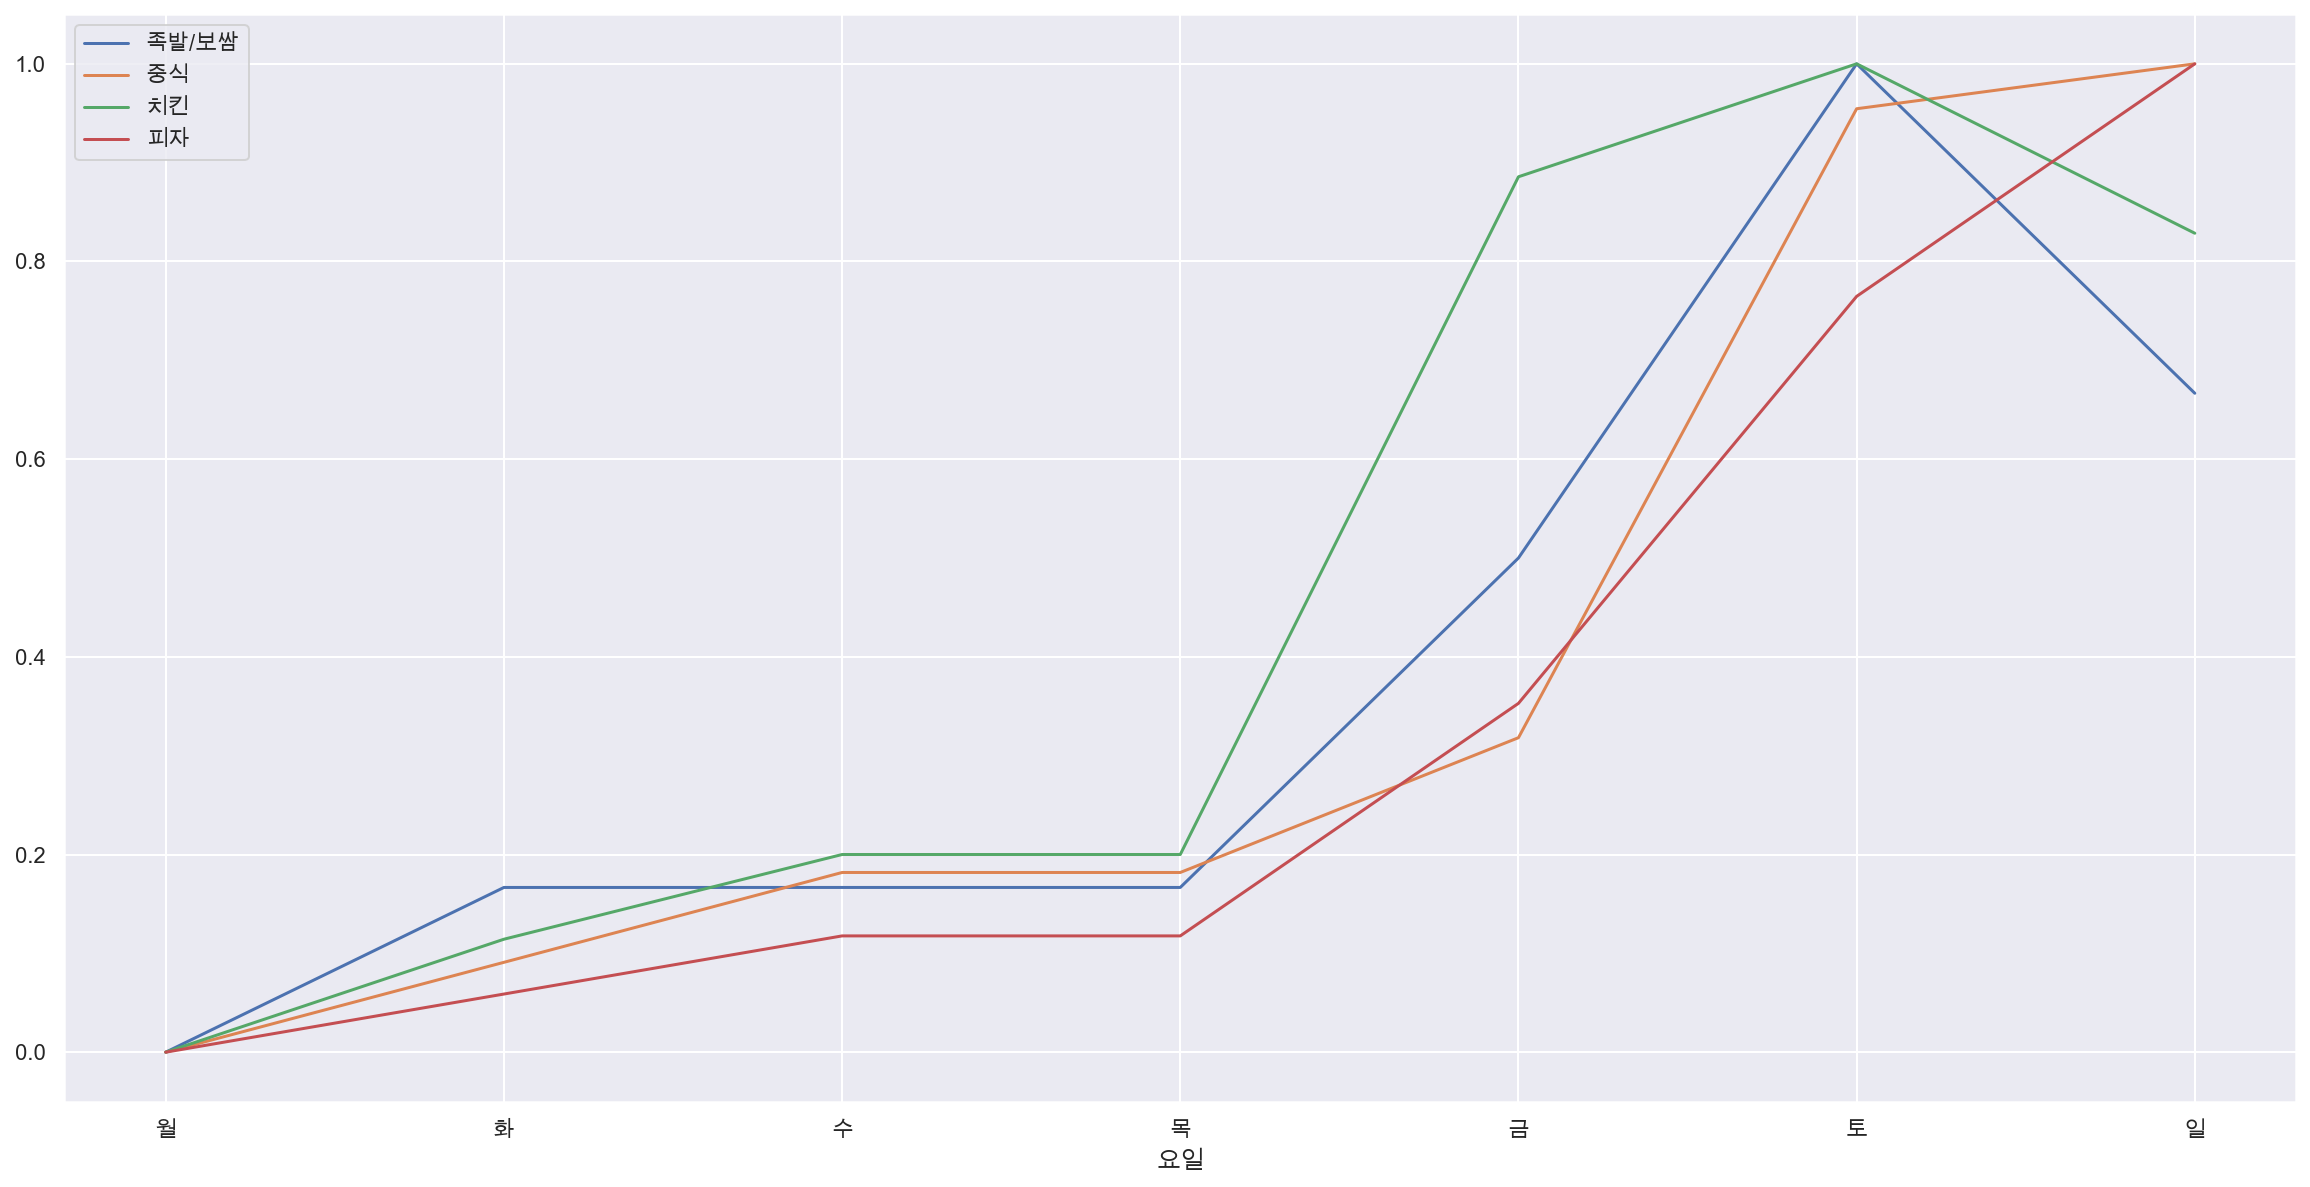

In [153]:
# 정규화
day_order_norm = pd.concat([day_order_sort["요일"], \
                            (day_order_sort[col]-day_order_sort[col].min()) / (day_order_sort[col].max()-day_order_sort[col].min())], axis=1)
day_order_norm.plot.line(x="요일", figsize=(20,10))
plt.show()

#### 2-4. 시간대별 특성분석

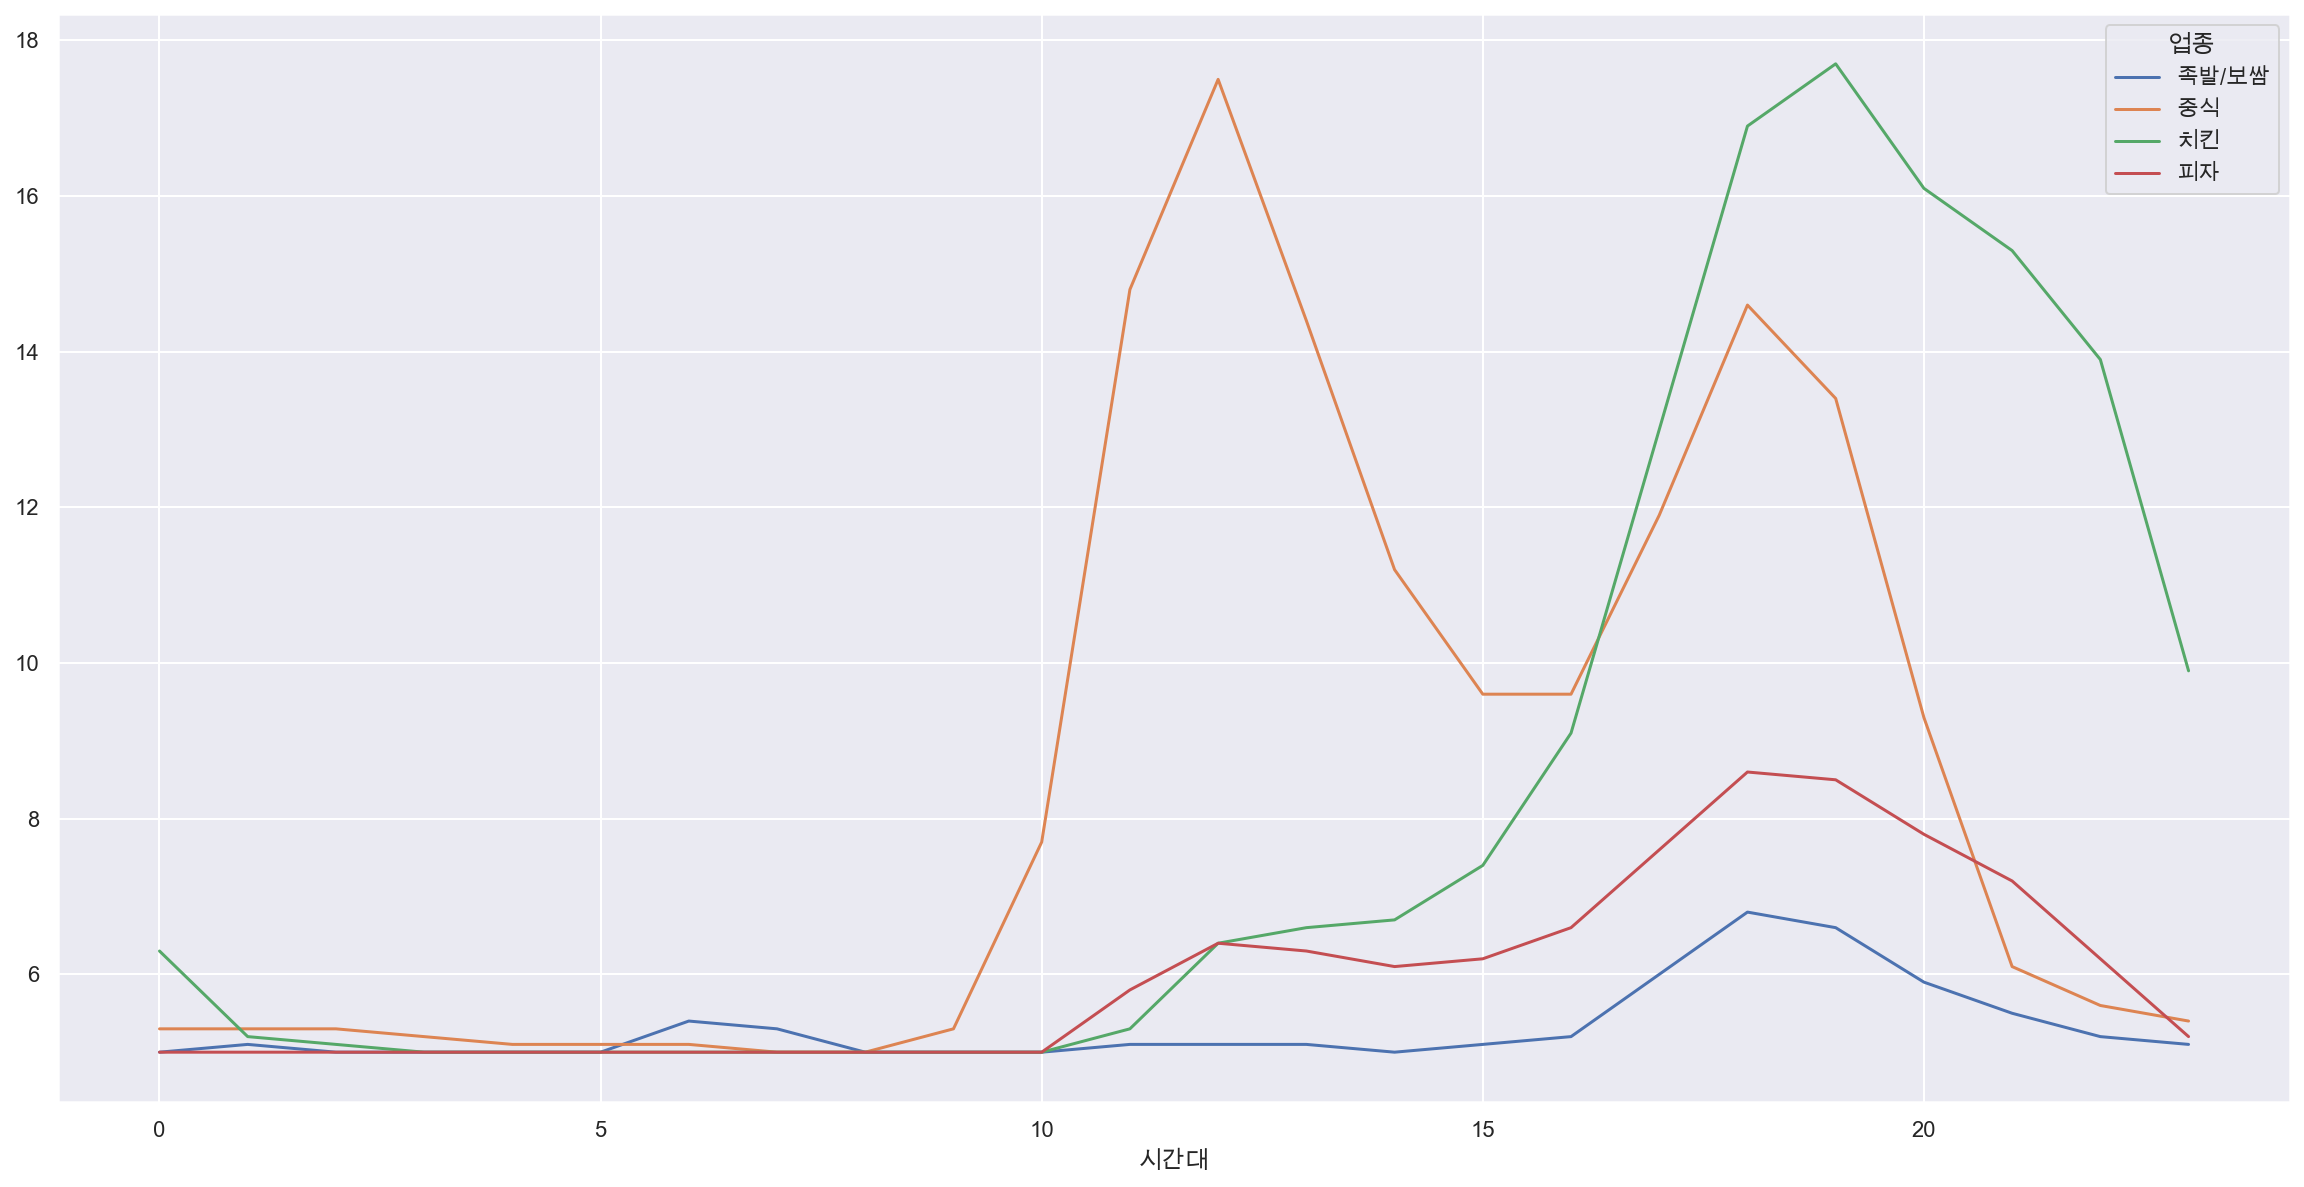

In [155]:
time_order = data.pivot_table("통화건수", "시간대", "업종").round(1).reset_index()
time_order.plot.line(x="시간대", figsize=(20,10))
plt.show();

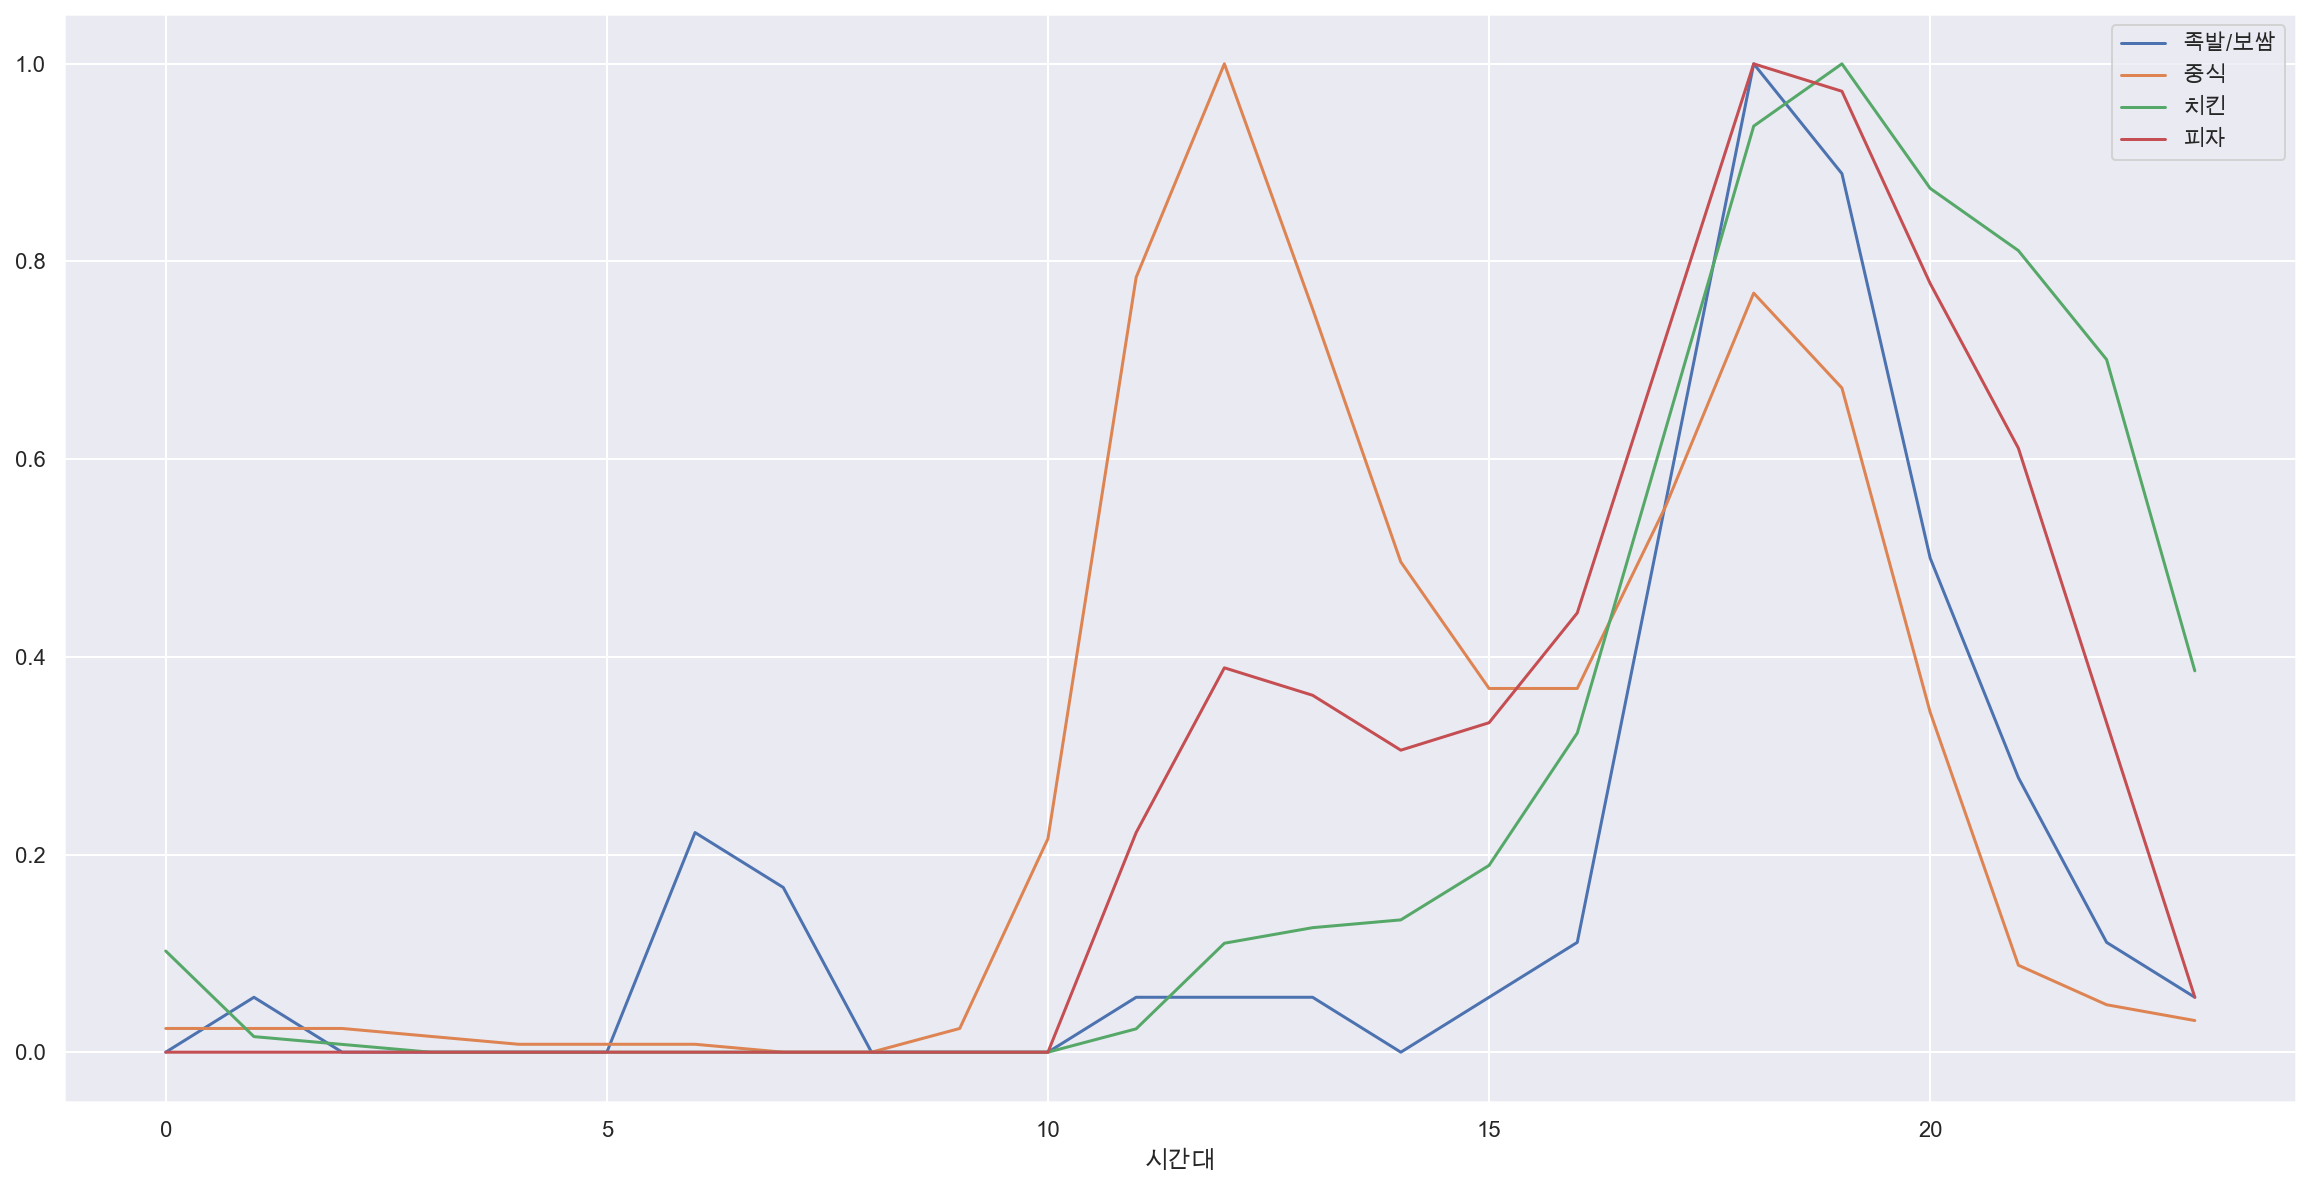

In [156]:
# 정규화
time_order = data.pivot_table("통화건수", "시간대", "업종").round(1).reset_index()
col = ["족발/보쌈", "중식", "치킨", "피자"]
time_order_norm = pd.concat([time_order["시간대"], (time_order[col]-time_order[col].min()) / (time_order[col].max()-time_order[col].min())], axis=1)
time_order_norm.plot.line(x="시간대", figsize=(20,10))
plt.show()